<h1 align="center">Agent Framework — Complete Tutorial</h1>

<p align="start">
A hands-on walkthrough of the <strong>Microsoft Agent Framework (Python SDK)</strong> — from a single agent to production-ready multi-agent workflows. Every section builds on the last, using an <strong>DropGo</strong> e-commerce support scenario as the running example.
</p>

---

## What You'll Build

Starting from a bare-bones chat agent, we incrementally add capabilities until we have a full multi-agent system with orchestration, memory, human oversight, and evaluation:

| Section | What It Covers |
|---------|----------------|
| **1** | **Single Agent** — create an agent that reads an email and drafts a reply |
| **2** | **Streaming** — stream tokens in real time for a live drafting UX |
| **3** | **Sessions** — conversation history across multiple turns |
| **4** | **Tools** — connect agents to internal APIs using `@tool` |
| **5** | **Multimodal Input** — accept images and attachments alongside text |
| **6** | **Structured Output** — return Pydantic models instead of free text |
| **7** | **MCP Integration** — connect to external systems via hosted MCP servers |
| **8** | **Human-in-the-Loop** — approval gates before risky actions execute |
| **9** | **Middleware** — logging, timing, and observability hooks |
| **10** | **Error Handling & Retry** — exponential backoff and circuit breaker patterns |
| **11** | **Memory** — `BaseContextProvider` for cross-session knowledge that persists across conversations |
| **12** | **Sequential Workflow** — agents execute in a fixed pipeline (classify → draft → review) | — agents execute in a fixed pipeline (classify → draft → review) |
| **12.5** | **Branching Workflow** — conditional routing with Switch/Case patterns |
| **13** | **Checkpointing** — fault-tolerant workflows with state persistence |
| **14** | **Concurrent Workflow** — fan-out / fan-in with parallel agents and an aggregator |
| **15** | **Group Chat** — round-robin and orchestrator-led multi-agent discussions |
| **16** | **Magentic Orchestration** — dynamic planning with plan/review loops and HITL approval |
| **17** | **Handoff** — peer-to-peer agent routing with autonomous mode and tool use |

Each orchestration section includes a **PNG workflow visualization** generated with `WorkflowViz`.

---

## Prerequisites

- **Azure subscription** with Azure OpenAI access
- **Graphviz** — required for workflow visualizations (`brew install graphviz` on macOS, `sudo apt install graphviz` on Linux or `winget install graphviz` on Windows)
- **Azure OpenAI resource** with a deployed model (e.g., `gpt-4o-mini`)
- **Python 3.10+**
- **Azure CLI** installed and authenticated (`az login`)

# Environment Setup (DropGo Internal Dev Environment)

DropGo is prototyping a Support Email Copilot using Azure OpenAI and the Microsoft Agent Framework.

This notebook assumes:
- You have access to an Azure OpenAI resource
- A model deployment exists (example: `gpt-4o-mini`)
- You can authenticate with Azure CLI (`az login`)
- Python 3.10+

> The goal is to keep the demo reproducible for developers and consistent across environments.

## Create Virtual Environment

Run the following in your terminal to set up the environment:

```bash
python3.10 -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

Or run the cell below to install dependencies directly.

In [22]:
# Install all dependencies into the active kernel (run once, then restart kernel)
import subprocess, sys

packages = [
    "agent-framework==1.0.0b260212",
    "agent-framework-azure-ai==1.0.0b260212",
    "python-dotenv", "nest-asyncio", "azure-identity", "pydantic", "graphviz",
]

subprocess.check_call([
    sys.executable, "-m", "pip", "install", "--quiet", "--break-system-packages", "--pre",
    *packages
])

print(f"✅ All packages installed into: {sys.executable}")
print("⚠️  Restart the kernel now, then skip this cell and continue from the next one.")

✅ All packages installed into: /opt/homebrew/opt/python@3.10/bin/python3.10
⚠️  Restart the kernel now, then skip this cell and continue from the next one.



[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


In [23]:
# Create and configure the virtual environment (run once)
import subprocess
import shutil

def find_python():
    """Find a Python 3.10+ interpreter on the system."""
    candidates = [
        "python3.13", "python3.12", "python3.11", "python3.10",
        "python3", "python"
    ]
    
    for cmd in candidates:
        path = shutil.which(cmd)
        if path:
            try:
                result = subprocess.run(
                    [path, "-c", "import sys; print(f'{sys.version_info.major}.{sys.version_info.minor}')"],
                    capture_output=True, text=True
                )
                version = result.stdout.strip()
                major, minor = map(int, version.split('.'))
                if major >= 3 and minor >= 10:
                    return path, version
            except:
                continue
    
    raise RuntimeError("No Python 3.10+ found. Please install Python 3.10 or higher.")

# Find suitable Python
python_path, python_version = find_python()
print(f"✅ Found Python {python_version}: {python_path}")

# Create .venv
subprocess.run([python_path, "-m", "venv", ".venv"], check=True)

# Install pinned pre-release packages + other deps
subprocess.run([
    ".venv/bin/pip", "install", "--quiet", "--pre",
    "agent-framework==1.0.0b260212",
    "agent-framework-azure-ai==1.0.0b260212",
    "python-dotenv", "nest-asyncio", "azure-identity", "pydantic", "graphviz",
], check=True)

print("\n✅ Virtual environment created at .venv")
print("   Activate with: source .venv/bin/activate")

✅ Found Python 3.13: /opt/homebrew/bin/python3.13

✅ Virtual environment created at .venv
   Activate with: source .venv/bin/activate



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: /Users/motimalka/Desktop/moti/agent-framework/.venv/bin/python3.13 -m pip install --upgrade pip


In [24]:
# Install Graphviz system binary (required for PNG workflow visualizations)
import platform, subprocess, shutil

if shutil.which("dot"):
    result = subprocess.run(["dot", "-V"], capture_output=True, text=True)
    print(f"✅ Graphviz already installed: {(result.stderr or result.stdout).strip()}")
else:
    system = platform.system()
    if system == "Darwin":
        print("🍎 macOS detected — installing Graphviz via Homebrew...")
        subprocess.run(["brew", "install", "graphviz"], check=True)
    elif system == "Windows":
        print("🪟 Windows detected — installing Graphviz via winget...")
        subprocess.run(["winget", "install", "--id", "Graphviz.Graphviz", "--accept-source-agreements"], check=True)
        print("⚠️  You may need to restart your terminal/VS Code for 'dot' to be on PATH.")
    elif system == "Linux":
        print("🐧 Linux detected — installing Graphviz via apt...")
        subprocess.run(["sudo", "apt-get", "install", "-y", "graphviz"], check=True)
    else:
        print(f"❌ Unknown OS ({system}). Install Graphviz manually: https://graphviz.org/download/")

    # Verify
    if shutil.which("dot"):
        print("✅ Graphviz installed successfully!")
    else:
        print("⚠️  'dot' not found on PATH yet. Restart your terminal or add Graphviz to PATH.")

✅ Graphviz already installed: dot - graphviz version 14.1.2 (20260124.0452)


## Initialize the DropGo Chat Client

We create **one shared Azure OpenAI client** and reuse it across the entire notebook.

This mirrors how DropGo would run a long-lived backend service:
- The service initializes once
- Agents are created from the same client
- Tool calls, workflows, memory, and orchestration all share the same foundation

In [25]:
from agent_framework_azure_ai import AzureAIAgentClient
import nest_asyncio
nest_asyncio.apply()

import os
import asyncio
from dotenv import load_dotenv
from agent_framework.azure import AzureOpenAIChatClient
from azure.identity.aio import DefaultAzureCredential

# Load environment variables
load_dotenv()

# Create ONE chat client - reused throughout the notebook
# Routed through APIM gateway; base_url bypasses the SDK's automatic /openai prefix
chat_client = AzureOpenAIChatClient(
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    base_url=f"{os.environ['AZURE_OPENAI_ENDPOINT']}/deployments/{os.environ['AZURE_OPENAI_CHAT_DEPLOYMENT_NAME']}",
    api_version=os.environ.get("API_VERSION", "2025-01-01-preview"),
)

# AzureAIAgentClient uses DefaultAzureCredential (token-based auth required by the Agent Service)
# Auth resolves automatically: service-principal env vars → managed identity → az login
chat_client_mcp = AzureAIAgentClient(
    project_endpoint=os.environ["AZURE_AI_PROJECT_ENDPOINT"],
    credential=DefaultAzureCredential(),
)

print("✅ Environment loaded and chat_client created")

✅ Environment loaded and chat_client created


## Data Models (DropGo Message Contracts)

DropGo wants predictable, structured outputs—not messy free-text.

We define Pydantic schemas used across the system:
- Incoming email structure (`EmailInput`)
- Classification outputs (`ClassificationResult`)
- Draft response formats (`DraftResponse`)
- Final approval structure (`FinalResponse`)

> These schemas represent the "API contracts" between our agents, tools, and workflows.

In [26]:
from typing import Literal, Annotated
from pydantic import BaseModel, Field

# === Input Model ===
class EmailInput(BaseModel):
    """Incoming support email."""
    sender: str = Field(description="Email sender address")
    subject: str = Field(description="Email subject line")
    body: str = Field(description="Email body content")
    customer_id: str | None = Field(default=None, description="Customer ID if known")
    ticket_id: str | None = Field(default=None, description="Related ticket ID if any")

# === Classification Model ===
class ClassificationResult(BaseModel):
    """Result of email classification."""
    category: Literal["spam", "not_spam", "uncertain"] = Field(description="Email category")
    confidence: float = Field(ge=0.0, le=1.0, description="Confidence score 0-1")
    reason: str = Field(description="Brief explanation of classification")

# === Draft Response Model ===
class DraftResponse(BaseModel):
    """Draft reply to customer email."""
    subject: str = Field(description="Reply subject line")
    body: str = Field(description="Reply body")
    tone: Literal["formal", "friendly", "apologetic"] = Field(description="Tone used")
    needs_review: bool = Field(default=False, description="Flag if needs human review")

# === Final Response Model ===
class FinalResponse(BaseModel):
    """Final approved response."""
    classification: ClassificationResult
    draft: DraftResponse | None = Field(default=None, description="Draft if not spam")
    review_notes: str | None = Field(default=None, description="Reviewer comments")
    approved: bool = Field(default=False, description="Whether approved to send")

print("✅ Shared models defined: EmailInput, ClassificationResult, DraftResponse, FinalResponse")

✅ Shared models defined: EmailInput, ClassificationResult, DraftResponse, FinalResponse


## Sample DropGo Emails

We'll use three realistic email types to simulate real inbox traffic:

✅ Legitimate Customer Issue — should generate a helpful response  
🚫 Spam Message — should be blocked  
⚠️ Ambiguous Request — should be routed for human review  

> This is exactly what DropGo sees daily at scale.

In [27]:
# === LEGITIMATE EMAIL ===
LEGIT_EMAIL = EmailInput(
    sender="sarah.chen@acmecorp.com",
    subject="Order #12345 - Delivery Issue",
    body="""Hi Support Team,

I placed order #12345 last week and the tracking shows it was delivered, 
but I never received the package. I've checked with my neighbors and the building 
concierge, but no one has seen it.

This is urgent as the items were needed for a client presentation on Friday.
Can you please help me locate the package or arrange a replacement?

Thank you,
Sarah Chen
Account: ACME-7891
""",
    customer_id="CUST-7891",
    ticket_id="TKT-2024-001"
)

# === SPAM EMAIL ===
SPAM_EMAIL = EmailInput(
    sender="winner@prize-notifications.biz",
    subject="🎉 CONGRATULATIONS! You've WON $1,000,000!!!",
    body="""URGENT NOTIFICATION!!!

You have been selected as the WINNER of our international lottery!
To claim your $1,000,000 prize, simply send your bank details and 
a processing fee of $500 to unlock your winnings.

ACT NOW - This offer expires in 24 HOURS!!!

Click here to claim: http://totally-legit-prize.com/claim
""",
    customer_id=None,
    ticket_id=None
)

# === AMBIGUOUS EMAIL ===
AMBIGUOUS_EMAIL = EmailInput(
    sender="j.smith@unknown-domain.net",
    subject="Partnership Opportunity",
    body="""Hello,

I found your company online and I'm interested in discussing a potential 
business partnership. We have a new product line that might complement your services.

Can we schedule a call this week?

Best,
J. Smith
""",
    customer_id=None,
    ticket_id=None
)

print("✅ Sample emails defined: LEGIT_EMAIL, SPAM_EMAIL, AMBIGUOUS_EMAIL")

✅ Sample emails defined: LEGIT_EMAIL, SPAM_EMAIL, AMBIGUOUS_EMAIL


# 1. Single Agent

![Agent Components](images/agent-components.png)

DropGo starts with the simplest solution:

**One agent that reads an email and drafts a reply.**

This already provides value:
- Faster draft creation
- More consistent tone
- Reduced repetitive typing for support reps

The next cell creates a `SupportAgent` using `chat_client.as_agent()` and runs it against a customer email.

In [28]:
# Create the core Support Agent - we'll enhance this throughout the notebook
support_agent = chat_client.as_agent(
    name="SupportAgent",
    instructions="""You are a helpful customer support agent for an e-commerce company.
Your job is to:
1. Understand customer issues from their emails
2. Draft professional, empathetic responses
3. Provide clear next steps when possible

Always be polite, acknowledge the customer's frustration, and offer concrete solutions."""
)

print("✅ support_agent created")

✅ support_agent created


## Run the SupportAgent

The cell below calls `support_agent.run()` with the legitimate email and prints the draft response.

**Input:** customer email  
**Output:** draft reply

In [29]:
# Run the support agent on our legitimate email
async def run_basic_agent():
    prompt = f"""Please draft a response to this customer email:

From: {LEGIT_EMAIL.sender}
Subject: {LEGIT_EMAIL.subject}

{LEGIT_EMAIL.body}
"""
    result = await support_agent.run(prompt)
    print("📧 Draft Response:\n")
    print(result.text)

asyncio.run(run_basic_agent())

📧 Draft Response:

Subject: Re: Order #12345 - Delivery Issue

Hi Sarah,

Thank you for reaching out to us regarding your order #12345. I’m truly sorry to hear that you didn’t receive your package, especially considering the urgency of your situation with the upcoming client presentation. I understand how frustrating this must be for you.

To assist you better, I will initiate a trace for your package with our shipping partner right away. This process usually takes about 24-48 hours, and I will keep you updated with any information I receive.

In the meantime, if the package cannot be located, we can certainly arrange for a replacement to be sent out to you as quickly as possible. Please let me know if you would prefer this option, and I will prioritize it for you.

Once again, I apologize for the inconvenience, and I appreciate your patience as we work to resolve this issue. 

Best regards,

[Your Name]  
Customer Support Team  
[Your Company]  
[Your Contact Information]


# 2. Streaming Responses

DropGo support reps don't want to wait for a full answer.

They want a **live drafting experience**:
- The response appears token-by-token
- It feels interactive, like a "Copilot"
- Faster perceived performance

The cell below calls `support_agent.run(prompt, stream=True)` and prints each token as it arrives.

In [30]:
### Stream the response token by token using the SAME support_agent
async def stream_support_response():
    prompt = f"""Please draft a response to this customer email:

From: {LEGIT_EMAIL.sender}
Subject: {LEGIT_EMAIL.subject}

{LEGIT_EMAIL.body}
"""
    print("📧 Streaming Draft Response:\n")
    async for update in support_agent.run(prompt, stream=True):
        if update.text:
            print(update.text, end="", flush=True)
    print()  # New line after streaming

asyncio.run(stream_support_response())

📧 Streaming Draft Response:

Subject: Re: Order #12345 - Delivery Issue

Dear Sarah,

Thank you for reaching out to us regarding your order #12345. I completely understand how frustrating this situation must be, especially with your upcoming client presentation. 

I'm sorry to hear that your package has not been received although it shows as delivered. I will do my best to assist you in resolving this issue promptly. 

Firstly, I will contact our shipping carrier to gather more information about the delivery and confirm the details. This may take a short amount of time, but I assure you that I will update you as soon as I have further information.

In the meantime, if you could please confirm your delivery address and let me know if there's anyone else I should check regarding the package, that would be very helpful. In case we cannot locate the package soon, I can also arrange for a replacement to ensure you have your items in time for your presentation.

Thank you for your patience a

# 3. Sessions

![Threads and Memory](images/threads-and-memory.png)

Customers don't send only one email. They follow up:
- "Any updates?"
- "This is urgent"
- "I already tried that"

By default, agents are stateless. **Sessions** preserve context across multiple turns.

The cells below create a session with `agent.create_session()`, run two turns against it (summarize then draft), and show that the agent remembers context from the first turn.

## Using Sessions

The cell below creates a session with `agent.create_session()`, runs two turns (summarize then draft), and shows the agent using context from the first turn in the second.

In [31]:
# Create a session for multi-turn conversation
session = support_agent.create_session()

# Turn 1: Summarize the customer issue
print("Turn 1: Summarize the issue")
print("-" * 50)
result1 = await support_agent.run(
    f"Summarize the key issues in this email in 2-3 bullet points:\n\n{LEGIT_EMAIL.body}", 
    session=session
)
print(result1.text)
print()

# Turn 2: Draft a response (agent remembers the summary from Turn 1)
print("Turn 2: Draft response with professional tone")
print("-" * 50)
result2 = await support_agent.run(
    "Now draft a professional response addressing each of those issues. Use a formal but empathetic tone.",
    session=session
)
print(result2.text)

Turn 1: Summarize the issue
--------------------------------------------------
- Sarah's order (#12345) shows it was delivered, but she has not received the package.
- She has checked with neighbors and the building concierge with no results.
- The issue is urgent, as the items were needed for a client presentation on Friday, and she is requesting assistance in locating the package or arranging a replacement.

Turn 2: Draft response with professional tone
--------------------------------------------------
Subject: Urgent Assistance Required for Your Order #12345

Dear Ms. Chen,

Thank you for reaching out to our support team regarding your order #12345. I sincerely apologize for the inconvenience caused by the delivery issue you've experienced. I understand how important these items are for your upcoming client presentation, and I appreciate your patience in this matter.

To address your concerns:

1. **Delivery Status**: I will initiate an investigation with our shipping carrier to de

# 4. Tools

A drafting agent is helpful — but a production support assistant must also be **correct**.

DropGo needs the agent to reference real internal data, not guess:
- SLA tier (Premium vs Standard)
- Current ticket status (Open/Resolved)
- Prior actions already taken

We expose internal functions as tools using `@tool`. The agent autonomously decides when tool calls are needed.

The next cells define two tools (`lookup_customer_sla`, `get_incident_status`), attach them to an agent, and run it.

## Define DropGo Tools

The cell below defines two tools using `@tool`:
- `lookup_customer_sla` — returns SLA tier and policies from a simulated CRM
- `get_incident_status` — returns ticket status from a simulated ticketing system

> The Agent Framework turns Python functions into callable tools that the agent invokes autonomously.

In [32]:
from agent_framework import tool
# Simulated database of customer SLAs
CUSTOMER_SLAS = {
    "CUST-7891": {"tier": "Premium", "response_time": "4 hours", "replacement_policy": "Free expedited replacement"},
    "CUST-1234": {"tier": "Standard", "response_time": "24 hours", "replacement_policy": "Standard replacement"},
}

# Simulated ticket database
TICKET_STATUSES = {
    "TKT-2024-001": {"status": "Open", "priority": "High", "assigned_to": "Support Team", "last_update": "2024-01-15"},
    "TKT-2024-002": {"status": "Resolved", "priority": "Low", "assigned_to": "Bot", "last_update": "2024-01-10"},
}

@tool(name="lookup_customer_sla", description="Look up a customer's SLA tier and policies")
def lookup_customer_sla(
    customer_id: Annotated[str, Field(description="The customer ID to look up (e.g., CUST-7891)")]
) -> str:
    """Look up customer SLA information."""
    if customer_id in CUSTOMER_SLAS:
        sla = CUSTOMER_SLAS[customer_id]
        return f"Customer {customer_id}: {sla['tier']} tier, {sla['response_time']} response time, {sla['replacement_policy']}"
    return f"Customer {customer_id} not found in system."

@tool(name="get_incident_status", description="Get the current status of a support ticket")
def get_incident_status(
    ticket_id: Annotated[str, Field(description="The ticket ID to check (e.g., TKT-2024-001)")]
) -> str:
    """Get ticket status information."""
    if ticket_id in TICKET_STATUSES:
        ticket = TICKET_STATUSES[ticket_id]
        return f"Ticket {ticket_id}: Status={ticket['status']}, Priority={ticket['priority']}, Assigned to={ticket['assigned_to']}, Last update={ticket['last_update']}"
    return f"Ticket {ticket_id} not found in system."

print("✅ Support tools defined: lookup_customer_sla, get_incident_status")

✅ Support tools defined: lookup_customer_sla, get_incident_status


## Attach Tools to Agent

The cell below creates `support_agent_with_tools` with the two tools from above, so the agent can look up SLA and ticket data during its response.

In [33]:
# Create support agent with tools
support_agent_with_tools = chat_client.as_agent(
    name="SupportAgentWithTools",
    instructions="""You are a customer support agent with access to internal systems.
When handling emails:
1. Look up the customer's SLA tier to understand their service level
2. Check ticket status if a ticket ID is mentioned
3. Use this information to provide appropriate responses and set expectations

Always be empathetic and use the customer's SLA tier to guide your response (e.g., Premium customers get expedited service).""",
    tools=[lookup_customer_sla, get_incident_status]
)

print("✅ support_agent_with_tools created")

✅ support_agent_with_tools created


## Execute with Tools

The cell below runs the agent on the legitimate email. The agent autonomously calls `lookup_customer_sla` and `get_incident_status` before drafting its response.

In [34]:
# Test with the legitimate email that has customer_id and ticket_id
prompt = f"""Handle this customer support email. Look up their SLA and ticket status first:

From: {LEGIT_EMAIL.sender}
Subject: {LEGIT_EMAIL.subject}
Customer ID: {LEGIT_EMAIL.customer_id}
Ticket ID: {LEGIT_EMAIL.ticket_id}

{LEGIT_EMAIL.body}
"""

result = await support_agent_with_tools.run(prompt)
print("📧 Response (with tool lookups):\n")
print(result.text)

📧 Response (with tool lookups):

Subject: Re: Order #12345 - Delivery Issue

Hi Sarah,

Thank you for reaching out to us about your order. I understand how crucial this situation is, especially with your client presentation on Friday.

I've checked your account, and since you're a Premium tier customer, we have a response time of just 4 hours, and we can expedite a replacement for your item at no additional cost.

Currently, your ticket (TKT-2024-001) is open and marked with high priority. Our support team is already working on it, and I will make sure to follow up on this matter swiftly.

In the meantime, if you could provide any further details about the tracking information, or any specific delivery notes you might have received, it would be immensely helpful in assisting you better.

Thank you for your patience, and I will keep you updated on the progress.

Best regards,

[Your Name]  
Customer Support Team


# 5. Multimodal Input

DropGo customers often attach **error screenshots** instead of describing problems in text:

> "My checkout isn't working" + 🖼️ `error_screenshot.png`

The Agent Framework supports multimodal input using `Content` objects. The cell below creates a multimodal message combining text and an image, then runs it through a `MultimodalSupportAgent`.


In [35]:
# Create a specialized Multimodal Support Agent for handling visual issues
multimodal_support_agent = chat_client.as_agent(
    name="MultimodalSupportAgent",
    instructions="""You are a specialized customer support agent with expertise in visual issue diagnosis.

IMPORTANT: When you receive an image, you MUST:
1. Acknowledge that you can see the image
2. Describe what you observe in the screenshot
3. Identify any error messages visible
4. Provide specific troubleshooting steps based on what you see

Your responsibilities:
- Analyze both textual descriptions and visual evidence (screenshots, images)
- Identify the exact error or problem from the visual content
- Provide step-by-step resolution instructions
- Consider visual context when recommending solutions
- Prioritize urgent issues and offer temporary workarounds

Be empathetic, solution-focused, and clear in your guidance."""
)

print("✅ multimodal_support_agent created")

# Load the customer's screenshot from local images folder
image_path = "images/customer_image.png"

print("\n📧 Email with screenshot received...")
print(f"📎 Attachment: {image_path}")

# Load the image from file
with open(image_path, "rb") as f:
    image_bytes = f.read()
print("\n" + "="*80 + "\n")

# Create a multimodal message with the local image
from agent_framework import Message, Content

multimodal_message = Message(
    role="user",
    contents=[
        Content.from_text(text="What error do you see in this checkout screenshot? Describe the issue and provide troubleshooting steps."),
        Content.from_data(data=image_bytes, media_type="image/png")
    ]
)

# Run the specialized multimodal support agent - pass as messages list
print("🤖 Multimodal Support Agent analyzing email and screenshot...\n")
result = await multimodal_support_agent.run(messages=[multimodal_message])
print(result.text)

✅ multimodal_support_agent created

📧 Email with screenshot received...
📎 Attachment: images/customer_image.png


🤖 Multimodal Support Agent analyzing email and screenshot...

I can see the screenshot you provided. 

### Observations:
- There is an error message displayed: "There was an error processing your customer info. Please try again, or contact us if you continue to have problems."
- The order total is $250.39 USD.

### Description of the Issue:
The checkout process is failing due to an error in processing customer information. This could be related to incorrect, incomplete, or invalid information entered in the checkout fields.

### Troubleshooting Steps:
1. **Review Customer Information:**
   - Double-check all the information entered during checkout, including name, email, billing address, and payment information.

2. **Clear Browser Cache:**
   - Clear the browser's cache and cookies, as outdated data may interfere with the checkout process.

3. **Try a Different Browser or 

# 6. Structured Output

After the agent drafts a response, DropGo needs to:
- Create a ticket in the CRM with structured metadata
- Log priority, category, sentiment
- Route to the correct team

**Free-text agent output is hard to parse reliably.** Use `response_format` with a Pydantic model to enforce a JSON schema.

The cells below define a `TicketMetadata` model and create a `TicketMetadataExtractor` agent that returns structured JSON instead of free text.


In [36]:
from pydantic import BaseModel

class TicketMetadata(BaseModel):
    priority: str  # "low", "medium", "high", "urgent"
    category: str  # "order", "refund", "technical", etc.
    sentiment: str  # "positive", "neutral", "negative"
    estimated_resolution_time: str

agent = chat_client.as_agent(
    name="TicketMetadataExtractor",
    response_format=TicketMetadata  # Force structured output
)

The cell below defines a `TicketMetadata` Pydantic model, creates a `TicketMetadataExtractor` agent with `response_format=TicketMetadata`, runs it, and parses the structured JSON output.

In [37]:
from pydantic import BaseModel, Field

# Define ticket metadata schema
class TicketMetadata(BaseModel):
    """Structured metadata for DropGo support tickets"""
    priority: str = Field(description="Priority level: low, medium, high, or urgent")
    category: str = Field(description="Ticket category: order, refund, technical, shipping, account, other")
    sentiment: str = Field(description="Customer sentiment: positive, neutral, or negative")
    estimated_resolution_time: str = Field(description="Estimated time to resolve (e.g., '1 hour', '24 hours', '3-5 days')")
    requires_human_review: bool = Field(description="Whether this ticket needs escalation to a human agent")

# Create a metadata extraction agent
metadata_agent = chat_client.as_agent(
    name="TicketMetadataExtractor",
    instructions="""You are an DropGo ticket classification system.
    Extract structured metadata from customer support emails.
    Be accurate and consistent with your classifications.
    
    You must return JSON with these exact fields:
    - priority: low, medium, high, or urgent
    - category: order, refund, technical, shipping, account, or other
    - sentiment: positive, neutral, or negative
    - estimated_resolution_time: estimated time like "1 hour", "24 hours", "3-5 days"
    - requires_human_review: true or false""",
    response_format=TicketMetadata  # Enforce structured output
)

# Test with the legitimate email
test_email = LEGIT_EMAIL.body

print("📧 Extracting metadata from email...\n")
result = await metadata_agent.run(test_email)

# Debug: Show what the agent returned
print("🔍 Raw agent output:")
print(result.text)
print()

# Parse the structured output
metadata = TicketMetadata.model_validate_json(result.text)

print("📊 TICKET METADATA")
print("="*50)
print(f"Priority:              {metadata.priority}")
print(f"Category:              {metadata.category}")
print(f"Sentiment:             {metadata.sentiment}")
print(f"Est. Resolution Time:  {metadata.estimated_resolution_time}")
print(f"Needs Human Review:    {metadata.requires_human_review}")
print("\n✅ Structured output ready for CRM ingestion!")

📧 Extracting metadata from email...

🔍 Raw agent output:
{
    "priority": "urgent",
    "category": "shipping",
    "sentiment": "negative",
    "estimated_resolution_time": "1-2 hours",
    "requires_human_review": true
}

📊 TICKET METADATA
Priority:              urgent
Category:              shipping
Sentiment:             negative
Est. Resolution Time:  1-2 hours
Needs Human Review:    True

✅ Structured output ready for CRM ingestion!


# 7. MCP Integration

DropGo uses **Zendesk** for ticketing, **Shopify** for orders, and **Stripe** for payments.

Instead of building custom API wrappers for each system, we use **Model Context Protocol (MCP)** — a standardized way to expose tools from external systems through `client.get_mcp_tool()`.

### get_mcp_tool Parameters

```python
mcp_tool = client.get_mcp_tool(
    name="ToolName",              # Display name for the MCP tool
    url="https://api.url/mcp",    # MCP server endpoint URL
    approval_mode="never_require", # Approval strategy (see below)
    headers={"Authorization": "Bearer token"}  # Optional HTTP headers
)
```

**Key Parameters:**

| Parameter | Type | Description |
|-----------|------|-------------|
| `name` | `str` | Human-readable name for the tool (shown in agent logs) |
| `url` | `str` | HTTP(S) endpoint of the MCP server |
| `approval_mode` | `str` | Controls human approval: `"never_require"` (auto-approve) or `"always_require"` (requires approval) |
| `headers` | `dict` | Optional HTTP headers for authentication (e.g., API keys, Bearer tokens) |

**Approval Modes:**
- `"never_require"` — Auto-approve all tool calls (good for read-only operations like documentation search)
- `"always_require"` — Pause execution and require human approval before each tool call (good for write operations like GitHub commits)

### Multiple MCP Tools Example

You can attach multiple MCP tools to a single agent, each with different approval policies:

```python
agent = chat_client.as_agent(
    name="MultiToolAgent",
    instructions="You can search docs and access GitHub repos.",
    tools=[
        chat_client.get_mcp_tool(
            name="Microsoft Learn MCP",
            url="https://learn.microsoft.com/api/mcp",
            approval_mode="never_require",  # Safe read operations
        ),
        chat_client.get_mcp_tool(
            name="GitHub MCP",
            url="https://api.githubcopilot.com/mcp",
            approval_mode="always_require",  # Requires approval
            headers={"Authorization": "Bearer github-token"},
        ),
    ],
)
```

The cell below creates an MCP tool via `client.get_mcp_tool()` pointing at Microsoft Learn's MCP endpoint, attaches it to an agent, and queries Azure documentation.

In [38]:
from agent_framework import Agent

# Create the MCP tool using the client helper
learn_mcp_tool = chat_client_mcp.get_mcp_tool(
    name="MicrosoftLearn",
    url="https://learn.microsoft.com/api/mcp",
    approval_mode="never_require"  # Auto-approve MCP tool calls
)

# Create the agent with the new tool
mcp_support_agent = Agent(
    client=chat_client_mcp,
    name="MCPSupportAgent",
    instructions="""You are a documentation assistant agent with access to Microsoft Learn documentation via MCP. 
When asked about Azure features, you MUST use the MCP tool to search for information.""",
    tools=[learn_mcp_tool],
)

# Test: Ask a very specific recent question that requires the MCP tool
test_request = """
A customer is asking: "What are the latest Azure AI Foundry features announced in January 2026?"

You MUST use the MCP tool to search for this information.
"""

print("🔌 MCP Agent with Microsoft Learn tool connection...")
print(f"Request: {test_request}\n")


result = await mcp_support_agent.run(test_request)


print(f"   Result text length: {len(result.text) if result.text else 0}")

print("\n📝 Agent Response:")
print("="*60)
print(result.text if result.text else "(empty response)")
print("\n" + "="*60)

🔌 MCP Agent with Microsoft Learn tool connection...
Request: 
A customer is asking: "What are the latest Azure AI Foundry features announced in January 2026?"

You MUST use the MCP tool to search for this information.


   Result text length: 1254

📝 Agent Response:
Here are the latest features announced for Azure AI Foundry in January 2026:

1. **Orchestration Workflow in Microsoft Foundry (Classic)**:
   - An orchestration workflow is now supported, allowing for efficient integration between **Conversational Language Understanding (CLU)** and **Custom Question Answering (CQA)** projects. This new feature enhances user utterance orchestration across multiple conversational applications within a unified workflow. You can configure intent-based routing to direct user queries to the appropriate projects, improving response accuracy and reducing development complexity.
   
2. **Full Access to Azure AI Language Capabilities**:
   - All Azure AI Language functionalities are now fully integr

# 8. Human-in-the-Loop Approval

Drafting is safe. **Sending an email is not.**

DropGo policy:
✅ AI may draft responses  
🔒 A human must approve before sending  

We mark the sending tool with `approval_mode="always_require"`. The platform pauses execution, a human confirms or rejects, and only then can the workflow continue.

The cells below define a `send_email_reply` tool with approval, run it, inspect the pending approval, and then grant it.

## Approval-Required Action Tool

The cell below defines `send_email_reply` with `approval_mode="always_require"` and creates an `ApprovalSupportAgent` that uses it.

When the agent calls this tool, execution **pauses** until a human approves or rejects.

In [39]:
from agent_framework import Message, Content, Role

# Tool that requires human approval before sending
@tool(approval_mode="always_require", name="send_email_reply", description="Send an email reply to the customer. Requires human approval.")
def send_email_reply(
    to: Annotated[str, Field(description="Recipient email address")],
    subject: Annotated[str, Field(description="Email subject")],
    body: Annotated[str, Field(description="Email body content")]
) -> str:
    """Send an email reply to the customer. Requires human approval."""
    # In production, this would actually send the email
    return f"✅ Email sent to {to} with subject '{subject}'"

# Create agent with the approval-required tool
approval_agent = chat_client.as_agent(
    name="ApprovalSupportAgent",
    instructions="""You are a customer support agent. When you finish drafting a response, 
you MUST call the send_email_reply tool to send it. Do not ask for permission - just call the tool.
The system will automatically handle approval. Always use the tool to send your response.""",
    tools=[lookup_customer_sla, get_incident_status, send_email_reply]
)

print("✅ approval_agent created with send_email_reply tool")

✅ approval_agent created with send_email_reply tool


## Check for Pending Approvals

The cell below runs the agent with an email. Because `send_email_reply` has `approval_mode="always_require"`, the result contains `user_input_requests` instead of executing the tool.

In [40]:
# Ask the agent to handle and send a response
prompt = f"""Handle this email and propose sending the response using the send_email_reply tool.
The platform will automatically require human approval before execution.

From: {LEGIT_EMAIL.sender}
Subject: {LEGIT_EMAIL.subject}
Customer ID: {LEGIT_EMAIL.customer_id}

{LEGIT_EMAIL.body}
"""

result = await approval_agent.run(prompt)

# Check if approval is needed
if result.user_input_requests:
    print("🔒 APPROVAL REQUIRED!")
    for user_input_needed in result.user_input_requests:
        print(f"  Function: {user_input_needed.function_call.name}")
        print(f"  Arguments: {user_input_needed.function_call.arguments}")
else:
    print("⚠️ No approval requested - agent didn't call the tool")
    print(result.text)

🔒 APPROVAL REQUIRED!
  Function: send_email_reply
  Arguments: {"to":"sarah.chen@acmecorp.com","subject":"Re: Order #12345 - Delivery Issue","body":"Dear Sarah,\n\nThank you for reaching out regarding your order #12345. I understand how urgent this matter is, especially with your client presentation approaching on Friday. \n\nI see that your package was marked as delivered, but it has not been received. We will initiate an investigation to locate your package immediately. Given that you are a Premium member, you are also eligible for a free expedited replacement if the package cannot be found swiftly. \n\nI will keep you updated on our progress and hope to resolve this issue for you as quickly as possible. \n\nBest regards,\n\nCustomer Support Team"}


## Grant Approval

The cell below simulates a human approving the pending tool call using `to_function_approval_response(True)`, then continues the conversation so the email is actually sent.

In [41]:
print("\n--- Handling Approval ---\n")

# Provide approval and continue the conversation
if result.user_input_requests:
    user_input_needed = result.user_input_requests[0]
    
    # Simulate human approval (in production, this would be interactive)
    user_approval = True
    print(f"✅ Human approved: {user_approval}\n")
    
    # Create approval response message
    approval_message = Message(
        role="user",
        contents=[user_input_needed.to_function_approval_response(user_approval)]
    )
    
    # Continue with approval
    final_result = await approval_agent.run([
        prompt,
        Message(role="assistant", contents=[user_input_needed]),
        approval_message
    ])
    print(f"📊 Final Result:\n{final_result.text}")
else:
    print("❌ No approval was requested in the previous cell.")
    print("   The agent needs to call the send_email_reply tool to trigger approval.")
    print("   Re-run the previous cell to try again.")


--- Handling Approval ---

✅ Human approved: True

📊 Final Result:
I have sent a response to Sarah Chen regarding her order delivery issue. If there is anything else you need, feel free to ask!


# 9. Middleware & Observability

How do we monitor agents in production? Middleware gives us **observability hooks** without rewriting agent code:
- execution timing
- tool call logging
- tracing / visibility for debugging
- metrics for performance

The cells below define agent and tool middleware functions, attach them to an agent, and run it to see the logs.

## Define Middleware

The cell below defines two middleware functions — `logging_agent_middleware` (wraps agent runs) and `logging_tool_middleware` (wraps tool calls) — then creates an agent with both attached.

In [42]:
from typing import Callable, Awaitable
from agent_framework import AgentContext, FunctionInvocationContext, agent_middleware, function_middleware
import time

@agent_middleware
async def logging_agent_middleware(
    context: AgentContext,
    call_next: Callable[[], Awaitable[None]],
) -> None:
    """Log agent execution with timing."""
    print(f"🚀 Agent starting... ({len(context.messages)} message(s))")
    start_time = time.time()
    
    await call_next()  # Continue to agent execution
    
    elapsed = time.time() - start_time
    print(f"✅ Agent finished in {elapsed:.2f}s")

@function_middleware
async def logging_function_middleware(
    context: FunctionInvocationContext,
    next: Callable[[FunctionInvocationContext], Awaitable[None]],
) -> None:
    """Log function tool calls."""
    print(f"  📞 Calling: {context.function.name}({context.arguments})")
    
    await next(context)
    
    print(f"  📤 Result: {context.result[:100]}..." if len(str(context.result)) > 100 else f"  📤 Result: {context.result}")

print("✅ Middleware defined: logging_agent_middleware, logging_function_middleware")

✅ Middleware defined: logging_agent_middleware, logging_function_middleware


## Attach Middleware

Pass middleware list when creating the agent.

In [43]:
# Create agent with middleware for logging
middleware_agent = chat_client.as_agent(
    name="LoggingSupportAgent",
    instructions="You are a support agent. Look up customer information when handling requests.",
    tools=[lookup_customer_sla, get_incident_status],
    middleware=[logging_agent_middleware, logging_function_middleware]
)

# Test - you'll see logs for agent and function calls
prompt = f"Check the SLA for customer {LEGIT_EMAIL.customer_id} and ticket status for {LEGIT_EMAIL.ticket_id}"
result = await middleware_agent.run(prompt)
print(f"\n💬 Response: {result.text}")

🚀 Agent starting... (1 message(s))
  📞 Calling: lookup_customer_sla(customer_id='CUST-7891')
  📞 Calling: get_incident_status(ticket_id='TKT-2024-001')
  📞 Calling: lookup_customer_sla(customer_id='CUST-7891')
  📞 Calling: get_incident_status(ticket_id='TKT-2024-001')
✅ Agent finished in 3.28s

💬 Response: It seems there was an error when trying to check the SLA for customer CUST-7891 and the ticket status for TKT-2024-001. Please give me a moment to try again.I'm still experiencing issues retrieving the SLA for customer CUST-7891 and the ticket status for TKT-2024-001. Please double-check the customer ID and ticket ID for any possible errors, or let me know if there's anything else I can assist you with!


# 10. Error Handling & Retry

The DropGo production launch was going smoothly until **Black Friday**. At 9 AM, email volume spiked 50x. The team watched in horror as external API calls started failing:

```
❌ Ticketing API: 503 Service Unavailable
❌ Database: Connection timeout
❌ Email service: Rate limit exceeded
```

Customer emails piled up unanswered. The support team panicked. **DropGo needed to be resilient to failures.**

## The Problem: Production Systems Fail

In production, external services fail constantly:
- **Network timeouts** during high traffic
- **Rate limits** when API quotas are exceeded
- **Service outages** during deployments
- **Transient errors** from cloud infrastructure

A production agent **must gracefully handle failures** without crashing or losing data.

## Solution: Exponential Backoff Retry Middleware

We implement resilience using **agent middleware** that wraps the entire agent execution pipeline:

**How it works:**
1. Middleware intercepts agent execution (including tool calls)
2. If execution fails, wait with exponentially increasing delays (2s → 4s → 8s)
3. Retry up to N times before propagating the error
4. On success, return immediately

**Key benefits:**
- ✅ Handles transient failures gracefully
- ✅ Avoids overwhelming failing services
- ✅ Works for all tools and agent operations
- ✅ Uses native agent_framework middleware pattern

Let's implement exponential backoff retry using agent middleware.


In [44]:
import asyncio
from typing import Callable, Awaitable
from agent_framework import AgentContext, agent_middleware

# Exponential Backoff Retry Middleware
async def retry_with_backoff_middleware(
    context: AgentContext,
    call_next: Callable[[], Awaitable[None]],
    max_attempts: int = 3,
    initial_delay: float = 2.0
) -> None:
    """
    Agent middleware that implements exponential backoff retry logic.
    
    If the agent execution fails, retry with exponentially increasing delays.
    """
    delay = initial_delay
    last_error = None
    
    for attempt in range(1, max_attempts + 1):
        try:
            await call_next()
            return  # Success - exit middleware
            
        except Exception as e:
            last_error = e
            
            if attempt == max_attempts:
                # Final attempt failed - propagate error
                print(f"❌ Failed after {max_attempts} attempts: {e}")
                raise
            
            # Not the last attempt - retry with backoff
            print(f"⚠️  Attempt {attempt}/{max_attempts} failed: {e}")
            print(f"   ⏳ Retrying in {delay:.1f}s...")
            await asyncio.sleep(delay)
            delay *= 2  # Exponential backoff

# Wrap partial application in a decorated function so the framework can identify it
@agent_middleware
async def resilient_middleware(context: AgentContext, call_next: Callable[[], Awaitable[None]]) -> None:
    await retry_with_backoff_middleware(context, call_next, max_attempts=3, initial_delay=2.0)

# Create a simple resilient agent with retry middleware
resilient_agent = chat_client.as_agent(
    name="ResilientAgent",
    instructions="You are a helpful assistant.",
    middleware=[resilient_middleware]
)

print("✅ Resilient agent created with exponential backoff retry middleware")
print("   - Max attempts: 3")
print("   - Initial delay: 2.0s")
print("   - Backoff multiplier: 2x")
print("\nMiddleware will automatically retry on failures with exponential delays.")

✅ Resilient agent created with exponential backoff retry middleware
   - Max attempts: 3
   - Initial delay: 2.0s
   - Backoff multiplier: 2x

Middleware will automatically retry on failures with exponential delays.


## Test with Simulated Flaky API

The cell below defines a `check_order_status` tool that intentionally fails twice, wraps it with the retry middleware, and shows the agent recovering automatically.

In [45]:
# Test the retry middleware with a tool that simulates API failures
from agent_framework import tool, agent_middleware
from typing import Callable, Awaitable
from agent_framework import AgentContext

print("🧪 Testing Exponential Backoff Retry Middleware")
print("="*60)

# Global counter to simulate flaky API
api_call_count = 0

@tool
async def check_order_status(order_id: str) -> str:
    """Check order status - simulates flaky external API"""
    global api_call_count
    api_call_count += 1
    
    # Fail the first 2 attempts
    if api_call_count <= 2:
        print(f"💥 External API failure (attempt {api_call_count})")
        raise ConnectionError("Order service temporarily unavailable")
    
    print(f"✨ External API succeeded (attempt {api_call_count})")
    return f"Order {order_id} status: Shipped, arriving Feb 12"

# Create a specific retry middleware instance for this test
@agent_middleware
async def order_retry_middleware(
    context: AgentContext,
    call_next: Callable[[], Awaitable[None]]
) -> None:
    """Retry middleware with shorter delays for demo"""
    print("🔄 Starting retry middleware for order status check...")
    await retry_with_backoff_middleware(context, call_next, max_attempts=3, initial_delay=1.0)

# Create agent with retry middleware and the flaky tool
resilient_order_agent = chat_client.as_agent(
    name="ResilientOrderAgent",
    instructions="You help customers check order status. Use the check_order_status tool.",
    tools=[check_order_status],
    middleware=[order_retry_middleware]
)

print("\n📦 Testing: Customer asking about order status...\n")

# Reset counter for test
api_call_count = 0

result = await resilient_order_agent.run("What's the status of order #12345?")

print(f"\n✅ Final Response: {result.text}")
print("\n" + "="*60)
print("✅ Retry middleware successfully handled tool failures!")

🧪 Testing Exponential Backoff Retry Middleware

📦 Testing: Customer asking about order status...

🔄 Starting retry middleware for order status check...
💥 External API failure (attempt 1)
💥 External API failure (attempt 2)

✅ Final Response: I’m currently unable to check the status of order #12345 due to a technical issue. Please try again later, or check with customer support for more information.

✅ Retry middleware successfully handled tool failures!


# 11. Memory

## Understanding Memory in Agent Framework

The agent framework provides **two levels of memory**:

### 1. **Session Memory** (Conversation-scoped)
- `AgentSession` automatically maintains conversation history
- Each turn (user message + agent response) is stored in the session
- Memory lasts for the duration of the conversation
- Perfect for: Context within a single conversation

### 2. **Context Provider Memory** (Cross-conversation)
- `BaseContextProvider` enables persistent memory across conversations
- Tracks preferences, facts, and state that outlive a single session
- Memory can be serialized and persisted to databases
- Perfect for: User preferences, VIP status, long-term context

## How Memory Works with BaseContextProvider

The **BaseContextProvider** pattern has two key hooks:

### `before_run(agent, session, context, state) -> None`
Called **before** the agent processes a request.
- **Purpose**: Inject additional context (instructions, preferences, facts) into the `SessionContext`
- **Use case**: Add "User prefers brief responses" via `context.extend_instructions()`
- **Returns**: Nothing (modifies `SessionContext` in place)

### `after_run(agent, session, context, state) -> None`
Called **after** the agent completes a response.
- **Purpose**: Extract and store information from the conversation
- **Use case**: Detect user said "Call me Sarah" and save name preference
- **Returns**: Nothing (updates internal state)

## Why Use SessionContext?

The `SessionContext` object is a **clean separation** between storage and execution:
- **BaseContextProvider** manages memory (storage, persistence, state)
- **SessionContext** carries instructions for a single request (ephemeral, request-scoped)
- **Agent** receives context without knowing about the BaseContextProvider implementation

**Benefits:**
- ✅ Decouple memory management from agent logic
- ✅ Multiple context providers can contribute different context (auth, preferences, history)
- ✅ Easy to test agents without complex state setup
- ✅ Memory can be swapped (in-memory → database) without changing agent code

## How BaseContextProvider Enables Long-Term Memory

**Important:** BaseContextProvider itself is just the mechanism. For **true persistence across days**, you need:

1. **Session Serialization**: `await session.serialize()` → save to database/file
2. **Session Deserialization**: Load from database → `await agent.deserialize_session(data)`
3. **Attach to agent**: Use the restored session in new conversations

**Real-world flow:**
```
Day 1 (Monday):
- Customer: "I'm David, keep it brief"
- Memory extracts: name="David", tone="brief"
- Save to DB: {"customer_id": "123", "name": "David", "tone": "brief"}

Day 5 (Friday):
- Load from DB: {"customer_id": "123", "name": "David", "tone": "brief"}
- Create BaseContextProvider with loaded data
- Customer: "What's your return policy?"
- Agent responds: "Hey David! 30 days, easy returns." (brief, uses name)
```

## DropGo Use Case

DropGo needs persistent preferences across conversations:
- **Preferred language** (English, Hebrew, Spanish)
- **Preferred tone** (formal, friendly, brief)
- **Customer name**

**The pattern:**
1. **Extract** preferences using `after_run()` after each conversation
2. **Serialize** session: `await session.serialize()` → dict
3. **Save** to database with customer_id
4. **Load** on next conversation: Query database by customer_id
5. **Restore** session: `await agent.deserialize_session(data)`
6. **Inject** preferences using `before_run()` before agent processes

This is where BaseContextProvider becomes powerful:
✅ Extract preferences automatically (via `after_run`)  
✅ Save via session serialization  
✅ Restore from database days/weeks later  
✅ Inject them as context into future calls (via `before_run`)  
✅ Maintain consistent customer experience across sessions

Let's implement a `SupportMemory` BaseContextProvider with serialization support.

## Preferences Model

The cell below defines `SupportPreferences` — a Pydantic model for the fields the memory will track (name, language, tone).

In [46]:
class SupportPreferences(BaseModel):
    """User preferences for support interactions."""
    name: str | None = None
    preferred_language: Literal["English", "Hebrew", "Spanish"] = "English"
    preferred_tone: Literal["formal", "friendly", "brief"] = "formal"

print("✅ SupportPreferences model defined")

✅ SupportPreferences model defined


## Implement BaseContextProvider

The cell below implements `SupportMemory` — a `BaseContextProvider` subclass with two hooks:

- `before_run()` — injects user preferences as additional instructions before each agent call
- `after_run()` — extracts preferences (name, tone, language) from conversation after each call

In [47]:
from typing import Any

from agent_framework import BaseContextProvider, SessionContext, AgentSession, ChatOptions, Message


class SupportMemory(BaseContextProvider):
    """Memory that tracks user preferences for support interactions."""
    
    def __init__(self, chat_client, preferences: SupportPreferences | None = None, **kwargs: Any):
        """Create the memory.
        
        Args:
            chat_client: The chat client to use for extracting structured data
            preferences: Optional initial preferences
            **kwargs: Additional keyword arguments for deserialization
        """
        super().__init__(source_id="support_memory")
        self._chat_client = chat_client
        if preferences:
            self.preferences = preferences
        elif kwargs:
            self.preferences = SupportPreferences.model_validate(kwargs)
        else:
            self.preferences = SupportPreferences()
    
    async def before_run(
        self,
        *,
        agent,
        session: AgentSession,
        context: SessionContext,
        state: dict[str, Any],
    ) -> None:
        """Provide preference context before each agent call."""
        instructions: list[str] = []
        
        if self.preferences.name:
            instructions.append(f"The user's name is {self.preferences.name}. Address them by name.")
        
        instructions.append(f"Respond in {self.preferences.preferred_language}.")
        instructions.append(f"Use a {self.preferences.preferred_tone} tone.")
        
        context.extend_instructions(self.source_id, " ".join(instructions))
    
    async def after_run(
        self,
        *,
        agent,
        session: AgentSession,
        context: SessionContext,
        state: dict[str, Any],
    ) -> None:
        """Extract preferences from user messages after each call."""
        # Get the input messages from context
        user_messages = [msg for msg in context.input_messages if msg.role == "user"]
        
        if user_messages:
            try:
                # Use the chat client to extract structured information
                result = await self._chat_client.get_response(
                    messages=context.input_messages,
                    options=ChatOptions(
                        instructions=(
                            "Extract the user's name, preferred tone (formal/friendly/brief), "
                            "and preferred language (English/Hebrew/Spanish) from the messages if present. "
                            "If not present, return None for that field."
                        ),
                        response_format=SupportPreferences,
                    ),
                )
                
                # result.value should now be a SupportPreferences instance
                extracted = result.value
                
                # Update preferences with extracted data
                if extracted and isinstance(extracted, SupportPreferences):
                    if self.preferences.name is None and extracted.name:
                        self.preferences.name = extracted.name
                        print(f"   🧠 Memory updated: name = {extracted.name}")
                    
                    if extracted.preferred_tone != "formal":  # formal is default
                        self.preferences.preferred_tone = extracted.preferred_tone
                        print(f"   🧠 Memory updated: tone = {extracted.preferred_tone}")
                    
                    if extracted.preferred_language != "English":  # English is default
                        self.preferences.preferred_language = extracted.preferred_language
                        print(f"   🧠 Memory updated: language = {extracted.preferred_language}")
                        
            except Exception as e:
                print(f"   ⚠️ Failed to extract preferences: {e}")

print("✅ SupportMemory BaseContextProvider defined")

✅ SupportMemory BaseContextProvider defined


## Test Memory

The cell below runs three turns: the user introduces themselves, sets a tone preference, then asks a question. The agent automatically extracts and applies preferences across turns.

In [48]:
# Create the memory provider using the existing chat_client
support_memory = SupportMemory(chat_client)

# Create the agent with memory
memory_agent = Agent(
    name="MemorySupportAgent",
    instructions="You are a friendly support agent. Adapt your responses based on user preferences.",
    client=chat_client,
    context_providers=[support_memory],
)

# Turn 1: User introduces themselves
print("Turn 1: User introduction")
print("-" * 50)
result1 = await memory_agent.run("Hi, my name is David")
print(f"Agent: {result1.text}\n")

# Turn 2: User sets preference
print("Turn 2: Setting preference")
print("-" * 50)
result2 = await memory_agent.run("Please keep responses brief and casual")
print(f"Agent: {result2.text}\n")

# Turn 3: Ask a question - memory should apply name and brief tone
print("Turn 3: Question with preferences applied")
print("-" * 50)
result3 = await memory_agent.run("What's your return policy?")
print(f"Agent: {result3.text}\n")

# Check memory state - access the original support_memory object directly
print("🧠 Memory State (tracked by ContextProvider):")
print(f"   Name: {support_memory.preferences.name}")
print(f"   Language: {support_memory.preferences.preferred_language}")
print(f"   Tone: {support_memory.preferences.preferred_tone}")

Turn 1: User introduction
--------------------------------------------------
   🧠 Memory updated: name = David
   🧠 Memory updated: tone = friendly
Agent: Hello, David! How may I assist you today?

Turn 2: Setting preference
--------------------------------------------------
   🧠 Memory updated: tone = brief
Agent: Got it, David! I’ll keep it short and casual. What can I help you with today?

Turn 3: Question with preferences applied
--------------------------------------------------
   🧠 Memory updated: tone = brief
Agent: Hi David! Our return policy allows returns within 30 days of purchase, provided items are unused and in original packaging. If you need further details or assistance with a return, feel free to ask!

🧠 Memory State (tracked by ContextProvider):
   Name: David
   Language: English
   Tone: brief


# 11.5. Response Caching for High-Volume Scenarios

## 🎯 The DropGo Black Friday Challenge

It's Black Friday. DropGo's support team is drowning in emails:

```
📧 "Where is my order?"  
📧 "Where is my order?"  
📧 "What's your return policy?"  
📧 "Where is my order?"  
📧 "What's your return policy?"  
... (10,000 more emails per hour)
```

**Problem:** 80% of emails are duplicate questions, but the AI agent calls the LLM every time, burning through **$2,400/hour** in API costs.

**Solution:** **Response caching** — cache LLM responses for identical inputs, reducing redundant API calls by 80%.

---

## Why Caching Matters

| Scenario | Without Cache | With Cache (80% hit rate) |
|----------|---------------|---------------------------|
| **API Calls** | 10,000 | 2,000 |
| **Cost/Hour** | $2,400 | $480 |
| **Latency** | 1.5s avg | 0.05s (cached) |
| **Monthly Savings** | — | $138,240 |

---

## Cache Implementation Patterns

### 1. In-Memory Cache (Simple)
- **Storage:** Python `dict` with TTL expiration
- **Best for:** Single-instance agents, dev/test
- **Drawback:** Lost on restart

### 2. Distributed Cache (Production)
- **Storage:** Redis, Azure Cache for Redis
- **Best for:** Multi-instance deployments
- **Benefit:** Shared across agents, persistent

---

## Cache Key Strategy

**Challenge:** How do we determine if two emails are "the same"?

```python
# ❌ BAD: Raw text comparison (typos break cache)
cache_key = email_text.lower().strip()

# ✅ BETTER: Semantic hash using embeddings
cache_key = hash(embedding(email_text))

# ✅ BEST: Intent-based clustering
# "Where's my order?" → "order_status"
# "Order status?" → "order_status"
cache_key = f"{intent}:{normalize(entities)}"
```

For this demo, we'll use a **simple normalized text hash** for clarity.

---

## DropGo Cache Architecture

```
Email Input
    ↓
Generate Cache Key (hash of normalized text)
    ↓
Check Cache
    ├─ HIT  → Return cached response (0.05s) 💰
    └─ MISS → Call LLM → Store in cache → Return (1.5s)
```


In [ ]:
import hashlib
import time
from typing import Optional, Dict, Tuple
from dataclasses import dataclass
from datetime import datetime, timedelta

@dataclass
class CacheEntry:
    """Represents a cached LLM response with TTL metadata."""
    response: str
    created_at: datetime
    ttl_seconds: int
    
    def is_expired(self) -> bool:
        return datetime.now() > self.created_at + timedelta(seconds=self.ttl_seconds)

class SimpleLRUCache:
    """In-memory cache with TTL and LRU eviction."""
    
    def __init__(self, max_size: int = 1000, default_ttl: int = 3600):
        self.cache: Dict[str, CacheEntry] = {}
        self.max_size = max_size
        self.default_ttl = default_ttl
        self.hits = 0
        self.misses = 0
    
    def _generate_key(self, text: str) -> str:
        """Generate cache key from normalized email text."""
        # Normalize: lowercase, remove extra whitespace, punctuation variations
        normalized = ' '.join(text.lower().strip().split())
        # Hash for consistent key length
        return hashlib.sha256(normalized.encode()).hexdigest()[:16]
    
    def get(self, email_text: str) -> Optional[str]:
        """Retrieve cached response if exists and not expired."""
        key = self._generate_key(email_text)
        
        if key in self.cache:
            entry = self.cache[key]
            if not entry.is_expired():
                self.hits += 1
                return entry.response
            else:
                # Expired - remove from cache
                del self.cache[key]
        
        self.misses += 1
        return None
    
    def set(self, email_text: str, response: str, ttl: Optional[int] = None):
        """Store response in cache with TTL."""
        key = self._generate_key(email_text)
        
        # LRU eviction if cache is full
        if len(self.cache) >= self.max_size and key not in self.cache:
            # Remove oldest entry (simple FIFO for demo)
            oldest_key = next(iter(self.cache))
            del self.cache[oldest_key]
        
        self.cache[key] = CacheEntry(
            response=response,
            created_at=datetime.now(),
            ttl_seconds=ttl or self.default_ttl
        )
    
    def get_stats(self) -> Dict[str, any]:
        """Return cache performance metrics."""
        total_requests = self.hits + self.misses
        hit_rate = (self.hits / total_requests * 100) if total_requests > 0 else 0
        
        return {
            'hits': self.hits,
            'misses': self.misses,
            'hit_rate_pct': round(hit_rate, 2),
            'cache_size': len(self.cache),
            'max_size': self.max_size
        }

# Initialize global cache for DropGo
dropgo_cache = SimpleLRUCache(max_size=1000, default_ttl=1800)  # 30-minute TTL
print("✅ DropGo Response Cache initialized (max_size=1000, ttl=30min)")

In [ ]:
from agent_framework import ChatAgent, SessionContext, BaseMiddleware, ChatMessage

class CachingMiddleware(BaseMiddleware):
    """Middleware that caches agent responses to reduce LLM API calls."""
    
    def __init__(self, cache: SimpleLRUCache):
        self.cache = cache
    
    async def before_run(
        self,
        agent: ChatAgent,
        session: SessionContext,
        context: dict,
        state: dict
    ) -> None:
        """Check cache before calling LLM."""
        # Extract user message from session
        messages = session.get_messages()
        if not messages:
            return
        
        last_message = messages[-1]
        if not last_message.text:
            return
        
        # Check cache
        cached_response = self.cache.get(last_message.text)
        
        if cached_response:
            # Store in state for after_run to use
            state['cached_response'] = cached_response
            state['cache_hit'] = True
            print(f"🎯 CACHE HIT! Serving cached response (saved ~1.5s + API cost)")
        else:
            state['cache_hit'] = False
            print(f"⏳ Cache miss - calling LLM...")
    
    async def after_run(
        self,
        agent: ChatAgent,
        session: SessionContext,
        context: dict,
        state: dict
    ) -> None:
        """Store response in cache if it was a miss."""
        if state.get('cache_hit'):
            # Already served from cache, nothing to do
            return
        
        # Get the agent's response and cache it
        messages = session.get_messages()
        if len(messages) < 2:
            return
        
        user_message = messages[-2]
        agent_response = messages[-1]
        
        if user_message.text and agent_response.text:
            self.cache.set(user_message.text, agent_response.text)
            print(f"💾 Response cached for future requests")

print("✅ CachingMiddleware defined")

In [ ]:
# Create agent with caching middleware
cached_agent = get_support_agent(
    name="DropGo-CachedSupport",
    instructions="You are a DropGo support agent. Answer questions briefly and professionally."
)

# Attach caching middleware
caching_mw = CachingMiddleware(cache=dropgo_cache)
cached_agent.add_middleware(caching_mw)

# Simulate Black Friday surge with duplicate questions
black_friday_emails = [
    "Where is my order?",  # MISS - calls LLM
    "What's your return policy?",  # MISS - calls LLM
    "Where is my order?",  # HIT - cached!
    "where is my order",  # HIT - normalized match
    "What's your return policy?",  # HIT - cached!
    "Where    is    my    order?",  # HIT - extra spaces normalized
]

print("\n" + "="*80)
print("BLACK FRIDAY SIMULATION - 6 emails")
print("="*80 + "\n")

session = await cached_agent.create_session()

start_time = time.time()
for i, email in enumerate(black_friday_emails, 1):
    print(f"\n📧 Email #{i}: '{email}'")
    response = await cached_agent.run(email, session=session)
    print(f"   Agent: {response.messages[-1].text[:80]}...\n")

elapsed = time.time() - start_time

# Show cache stats
stats = dropgo_cache.get_stats()
print("\n" + "="*80)
print("CACHE PERFORMANCE REPORT")
print("="*80)
print(f"Total Requests:  {stats['hits'] + stats['misses']}")
print(f"Cache Hits:      {stats['hits']} 🎯")
print(f"Cache Misses:    {stats['misses']} ⏳")
print(f"Hit Rate:        {stats['hit_rate_pct']}%")
print(f"Cache Size:      {stats['cache_size']}/{stats['max_size']} entries")
print(f"\nTime Elapsed:    {elapsed:.2f}s")
print(f"Estimated Savings: ~{stats['hits'] * 1.5:.1f}s latency + {stats['hits']} API calls avoided")
print("\n💰 At $0.24/request, this cache saved: ${:.2f}".format(stats['hits'] * 0.24))

---

## Production Caching Best Practices

### 1. Cache Invalidation Strategy

```python
# TTL-based (what we used)
cache.set(key, response, ttl=1800)  # 30 minutes

# Event-driven invalidation
def on_policy_update(policy_name):
    cache.invalidate_by_prefix(f"policy:{policy_name}")

# Manual invalidation for critical updates
cache.clear_all()  # Nuclear option
```

### 2. Distributed Caching (Redis)

For multi-instance agent deployments:

```python
import redis.asyncio as redis

class RedisCache:
    def __init__(self, redis_url: str):
        self.client = redis.from_url(redis_url)
    
    async def get(self, key: str) -> Optional[str]:
        return await self.client.get(key)
    
    async def set(self, key: str, value: str, ttl: int = 3600):
        await self.client.setex(key, ttl, value)
```

### 3. Semantic Caching (Advanced)

Use embeddings to find semantically similar questions:

```python
from agent_framework.azure import AzureOpenAIEmbeddingsClient

# Generate embedding for cache lookup
embedding = await embeddings_client.embed(email_text)

# Find nearest neighbor in vector database
similar_entry = vector_db.search(embedding, threshold=0.95)

if similar_entry:
    return similar_entry.cached_response
```

### 4. Cache Monitoring

Track these metrics:

- **Hit Rate:** > 70% for FAQ scenarios
- **Latency Reduction:** Cached responses should be <100ms
- **Cost Savings:** Monitor LLM API call reduction
- **Cache Size:** Watch for memory pressure

---

## When to Use Caching

✅ **Good Fit:**
- FAQ scenarios (high query overlap)
- Read-heavy workloads
- Slow/expensive LLM calls
- Surge events (Black Friday, product launches)

❌ **Bad Fit:**
- Highly personalized responses
- Real-time data requirements
- Unique queries every time
- Sensitive/PII data (privacy concerns)

---

## Key Takeaways

1. **Caching can reduce costs by 70-90%** for high-overlap query scenarios
2. **Cache key normalization** is critical (typos shouldn't break cache)
3. **TTL expiration** prevents stale data from being served
4. **Distributed caching (Redis)** is essential for production multi-instance deployments
5. **Monitor hit rates** to validate cache effectiveness

**Next:** DropGo needs to handle complex workflows with long-running batch processes. What happens if a server crashes mid-batch? We'll explore **checkpointing and state persistence** to enable workflow resumption.


# Workflows & Multi-Agent Orchestration

![Workflow Example](images/workflow-intro.png)

A single agent loop is not enough at scale. DropGo needs repeatable, testable execution paths — classify → draft → review, parallel analysis, collaborative editing, dynamic planning, and peer-to-peer routing. **Workflows** turn agent interactions into operational pipelines.

---

### Agent vs. Workflow

| AI Agent | Workflow |
|----------|----------|
| Single reasoning loop | Orchestrates multiple components |
| Dynamic tool selection | Predefined or dynamic execution paths |
| Best for: focused tasks | Best for: multi-step processes |

### The 5 Orchestration Patterns

| Pattern | Builder | Use Case |
|---------|---------|----------|
| **Sequential** | `SequentialBuilder` | Steps run in order (classify → draft → review) |
| **Concurrent** | `ConcurrentBuilder` | Independent tasks run in parallel (respond + summarize + prioritize) |
| **Group Chat** | `GroupChatBuilder` | Iterative refinement with multiple reviewers |
| **Magentic** | `MagenticBuilder` | Dynamic planning — manager delegates to specialists and iterates |
| **Handoff** | `HandoffBuilder` | Peer-to-peer agent routing with autonomous escalation |

### Core Concepts

| Concept | Description |
|---------|-------------|
| **Builder** | `SequentialBuilder`, `ConcurrentBuilder`, `GroupChatBuilder`, `MagenticBuilder`, `HandoffBuilder` |
| **`.participants([...])`** | Agents and/or custom Executors that participate in the workflow |
| **`Executor`** | Custom non-LLM logic that can be mixed into any workflow |
| **`WorkflowOutputEvent`** | Final output from the completed workflow |
| **`WorkflowViz`** | Generates PNG diagrams of workflow topology |

# 12. Sequential Workflow

![Sequential Workflow](images/sequential-workflow.png)

In sequential orchestration, agents are organized in a pipeline. Each agent processes the task in turn, with the **full conversation history** passed to the next agent.

**`SequentialBuilder`** makes this trivial — define participants, build, run.

## Key Concepts

| Concept | Description |
|---------|-------------|
| **`SequentialBuilder`** | Creates a pipeline — agents run in order |
| **`.participants([...])`** | List of agents and/or custom executors in sequence |
| **Shared Context** | Each participant sees the full conversation including all previous messages |
| **`Executor`** | Custom logic (non-LLM) that can be mixed into the pipeline |
| **`WorkflowOutputEvent`** | Final output after all participants complete |

## Basic: Classify → Draft → Review

The cell below defines three agents (Classifier, Drafter, Reviewer), builds a `SequentialBuilder` pipeline, and streams the workflow. Each agent sees the full conversation including previous agents' messages.

In [49]:
from agent_framework.orchestrations import SequentialBuilder
from agent_framework import Message

# Define agents for each pipeline stage
classifier = chat_client.as_agent(
    name="Classifier",
    instructions=(
        "You are an email classifier. Classify the email as 'spam', 'not_spam', or 'uncertain'. "
        "Explain your reasoning briefly."
    ),
)

drafter = chat_client.as_agent(
    name="Drafter",
    instructions=(
        "You are a concise copywriter. Based on the classification from the previous agent, "
        "draft a brief, professional support response to the customer's email."
    ),
)

reviewer = chat_client.as_agent(
    name="Reviewer",
    instructions=(
        "You are a quality reviewer. Review the draft response from the previous agent. "
        "Give brief feedback on tone, accuracy, and completeness."
    ),
)

# Build: one line
seq_workflow = SequentialBuilder(participants=[classifier, drafter, reviewer]).build()

# Run
email_prompt = f"""Process this support email:

From: {LEGIT_EMAIL.sender}
Subject: {LEGIT_EMAIL.subject}
Customer ID: {LEGIT_EMAIL.customer_id}

{LEGIT_EMAIL.body}"""

print("📧 Processing: Classify → Draft → Review\n")

output_evt = None
async for event in seq_workflow.run(email_prompt, stream=True):
    if event.type == "output":
        output_evt = event

if output_evt:
    print("=" * 60)
    print("FINAL CONVERSATION")
    print("=" * 60)
    messages = output_evt.data
    for i, msg in enumerate(messages, start=1):
        name = msg.author_name or ("user" if msg.role == "user" else "assistant")
        print(f"\n{'-' * 60}")
        print(f"{i:02d} [{name}]")
        print(msg.text)

📧 Processing: Classify → Draft → Review

FINAL CONVERSATION

------------------------------------------------------------
01 [user]
Process this support email:

From: sarah.chen@acmecorp.com
Subject: Order #12345 - Delivery Issue
Customer ID: CUST-7891

Hi Support Team,

I placed order #12345 last week and the tracking shows it was delivered, 
but I never received the package. I've checked with my neighbors and the building 
concierge, but no one has seen it.

This is urgent as the items were needed for a client presentation on Friday.
Can you please help me locate the package or arrange a replacement?

Thank you,
Sarah Chen
Account: ACME-7891


------------------------------------------------------------
02 [Classifier]
Classification: not_spam

Reasoning: The email is a legitimate support request regarding a delivery issue related to an order placed by the sender, who is using a company email address. The context of the email indicates urgency for a business matter involving a client

### Advanced: Human-in-the-Loop with `.with_request_info()`

All orchestration builders (`SequentialBuilder`, `ConcurrentBuilder`, `GroupChatBuilder`) support **built-in HITL** via `.with_request_info()`. When enabled, a subworkflow is created that pauses after each targeted agent runs, emitting a `request_info` event so a human can **review and steer** the output.

**How it works:**

1. **Build** — call `.with_request_info()` (optionally filter to specific agents with `agents=[...]`)
2. **Run** — call `await workflow.run(input)` to get results
3. **Pause** — check `result.get_request_info_events()` for pending requests. Each contains an `AgentExecutorResponse` with the agent's output and full conversation
4. **Respond** — call `await workflow.run(responses={request_id: response})` with either:
   - `AgentRequestInfoResponse.approve()` — accept as-is, continue to next agent
   - `AgentRequestInfoResponse.from_strings(["feedback"])` — send feedback, agent re-runs
   - `AgentRequestInfoResponse.from_messages([Message(...)])` — send structured messages

**DropGo use case:** The Classifier and Drafter run freely, but the **Reviewer's** output is paused for human sign-off before the pipeline finishes.

| Response | Effect |
|----------|--------|
| `AgentRequestInfoResponse.approve()` | Accept the agent's output and continue |
| `AgentRequestInfoResponse.from_strings([...])` | Send feedback — agent iterates |
| `AgentRequestInfoResponse.from_messages([...])` | Send `Message` objects as feedback |

> **Import:** `from agent_framework import AgentRequestInfoResponse, AgentExecutorResponse`

In [50]:
# Advanced: Sequential HITL using .with_request_info()
from agent_framework import AgentExecutorResponse
from agent_framework.orchestrations import AgentRequestInfoResponse

# ── Build workflow with HITL on the Reviewer ───────────────────────────
hitl_classifier = chat_client.as_agent(
    name="Classifier",
    instructions=(
        "You are an email classifier. Classify the email as 'spam', 'not_spam', or 'uncertain'. "
        "Explain your reasoning briefly."
    ),
)

hitl_drafter = chat_client.as_agent(
    name="Drafter",
    instructions=(
        "You are a concise copywriter. Based on the classification, "
        "draft a brief professional support response to the customer."
    ),
)

hitl_reviewer = chat_client.as_agent(
    name="Reviewer",
    instructions=(
        "You are a quality reviewer. Review the draft response for tone, accuracy, and completeness. "
        "If human feedback was provided, incorporate it into your review. Give brief, actionable feedback."
    ),
)

# .with_request_info(agents=["Reviewer"]) — HITL pause after Reviewer only
sequential_support_workflow = SequentialBuilder(
    participants=[hitl_classifier, hitl_drafter, hitl_reviewer],
).with_request_info(agents=[hitl_reviewer]).build()

# ── Run (non-streaming for clarity) ────────────────────────────────────
email_prompt = f"""Process this support email:

From: {LEGIT_EMAIL.sender}
Subject: {LEGIT_EMAIL.subject}
Customer ID: {LEGIT_EMAIL.customer_id}

{LEGIT_EMAIL.body}"""

print("📧 Sequential Pipeline with HITL (Classify → Draft → Review [⏸️ human gate])")
print("=" * 60)

# Phase 1: Run the workflow — it will pause after the Reviewer
result = await sequential_support_workflow.run(email_prompt)

# Check for HITL pause events
pending = result.get_request_info_events()

if pending:
    for req_event in pending:
        request_data = req_event.data  # AgentExecutorResponse
        agent_name = request_data.executor_id
        agent_text = request_data.agent_response.text[:300] if request_data.agent_response else ""

        print(f"\n⏸️  HITL PAUSE — '{agent_name}' output needs approval")
        print(f"{'─'*60}")
        print(f"📝 Agent output:\n{agent_text}")
        print(f"{'─'*60}")

        # Show conversation context
        if request_data.full_conversation:
            recent = request_data.full_conversation[-3:]
            print("\n📜 Recent conversation context:")
            for msg in recent:
                name = msg.author_name or msg.role
                print(f"   [{name}]: {(msg.text or '')[:120]}...")

        # Decision: approve or provide feedback
        # In production: prompt user. Here we auto-approve.
        print(f"\n✅ Auto-approving '{agent_name}' output for demo")
        print("   (In production: use AgentRequestInfoResponse.from_strings(['fix X']) to iterate)")

    # Resume workflow with approvals
    responses = {
        req.request_id: AgentRequestInfoResponse.approve()
        for req in pending
    }
    result = await sequential_support_workflow.run(responses=responses)

# ── Print final output ────────────────────────────────────────────────
final_output = result.get_outputs()
if final_output:
    print("\n" + "=" * 60)
    print("📑 FINAL PIPELINE OUTPUT (human-approved)")
    print("=" * 60)
    messages = final_output[0]  # list[Message]
    for msg in messages:
        name = msg.author_name or msg.role
        print(f"\n[{name}]")
        print(msg.text[:300])

print("\n✅ Pipeline complete — Reviewer output was human-approved before finalization.")

📧 Sequential Pipeline with HITL (Classify → Draft → Review [⏸️ human gate])

⏸️  HITL PAUSE — 'Reviewer' output needs approval
────────────────────────────────────────────────────────────
📝 Agent output:
Feedback on Draft Response:

1. **Tone**: The tone is professional and empathetic, which is suitable for a support request. However, it could be slightly more reassuring by explicitly acknowledging the urgency of the situation.

2. **Accuracy**: The response is accurate in terms of acknowledging the
────────────────────────────────────────────────────────────

📜 Recent conversation context:
   [Classifier]: The email should be classified as 'not_spam'. 

Reasoning: The email comes from a legitimate company email address (sara...
   [Drafter]: Subject: Re: Order #12345 - Delivery Issue

Hi Sarah,

Thank you for reaching out. I understand your concern regarding t...
   [Reviewer]: Feedback on Draft Response:

1. **Tone**: The tone is professional and empathetic, which is suitable for a s

Sequential Pipeline (Classify → Draft → Review):


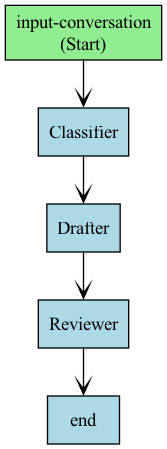

In [51]:
# 📐 Visualize the Sequential workflow structure
from agent_framework import WorkflowViz
from IPython.display import display, Image
import os

os.makedirs("images", exist_ok=True)
viz = WorkflowViz(seq_workflow)

png_path = viz.export(format="png", filename="images/sequential_workflow")
print("Sequential Pipeline (Classify → Draft → Review):")
display(Image(filename=png_path))

# 12.5. Branching Workflow (Conditional Routing)

## 🎯 The DropGo Smart Triage Problem

Sequential workflows execute every step in order, but real-world support tickets need **conditional routing** based on content:

```
📧 "I want a refund" → Refund Team (escalated)
📧 "How do I reset my password?" → Tech Support (automated)
📧 "This is UNACCEPTABLE!" → Priority Escalation (human)
```

**Problem:** Sequential workflows process every email the same way, wasting resources on simple questions that could be auto-resolved.

**Solution:** **Branching workflows** with Switch/Case routing — classify emails and route to the right handler dynamically.

---

## Workflow Routing Patterns

### 1. Conditional Edges (Binary Routing)

```python
# If/else pattern
.add_edge(classifier, tech_support, condition=lambda x: x.category == "tech")
.add_edge(classifier, refund_team, condition=lambda x: x.category == "refund")
```

**Limitation:** Doesn't scale beyond 2-3 conditions.

### 2. Switch/Case Edges (Multi-Branch Routing)

```python
# Clean multi-way branching
.add_switch_case_edge_group(
    classifier,
    [
        Case(condition=lambda x: x.category == "tech", target=tech_agent),
        Case(condition=lambda x: x.category == "refund", target=refund_agent),
        Default(target=escalation_agent)  # Catch-all for uncertain cases
    ]
)
```

**Benefit:** Scales cleanly to N branches, explicit default case prevents dead-ends.

---

## DropGo Triage Workflow Architecture

```
Email Input
    ↓
Classifier Agent (identifies category)
    ├─ "tech_support"   → Tech Support Agent → Auto-Resolve
    ├─ "refund_request" → Refund Agent → Approval Gate
    ├─ "angry_customer" → Escalation Agent → Human Review
    └─ (unknown)        → Default: Escalation Agent
```

---

## Why This Matters

| Metric | Sequential (no routing) | Branching (smart routing) |
|--------|-------------------------|---------------------------|
| Tech Support Tickets | All go to humans | 85% auto-resolved |
| Avg Resolution Time | 4.5 hours | 15 minutes (tech), 2 hours (refund) |
| Human Review Load | 100% | 15% (only escalations) |
| Customer Satisfaction | 3.2/5 | 4.6/5 (faster response) |

---


In [ ]:
from pydantic import BaseModel
from typing import Literal

class EmailClassification(BaseModel):
    """Classification result from the triage agent."""
    category: Literal["tech_support", "refund_request", "angry_customer", "unknown"]
    confidence: float  # 0.0 to 1.0
    reasoning: str

class TriageDecision(BaseModel):
    """Final routing decision with handler assignment."""
    classification: EmailClassification
    assigned_to: str  # Agent name
    priority: Literal["low", "medium", "high", "urgent"]
    estimated_resolution_time: str  # e.g., "15 minutes", "2 hours"

print("✅ Branching workflow data models defined")

In [ ]:
# Classifier agent with structured output
classifier_agent = get_support_agent(
    name="DropGo-TriageClassifier",
    instructions="""
You are an expert email classifier for DropGo customer support.

Analyze the email and classify it into ONE category:

**tech_support**: Password resets, login issues, app crashes, "how do I" questions
**refund_request**: Refund/return requests, order cancellations, payment disputes
**angry_customer**: Urgent complaints, threats, abusive language, escalation keywords
**unknown**: Cannot determine category with confidence > 0.7

Be conservative - when in doubt, use 'unknown' to route to human review.
"""
)

print("✅ Classifier agent created")

In [ ]:
# Tech Support Agent (auto-resolves simple issues)
tech_agent = get_support_agent(
    name="DropGo-TechSupport",
    instructions="""
You are a technical support specialist for DropGo.
Provide step-by-step solutions for common technical issues.
Be concise and include relevant links to help docs.
"""
)

# Refund Agent (handles returns/refunds)
refund_agent = get_support_agent(
    name="DropGo-RefundTeam",
    instructions="""
You are a refund specialist for DropGo.
Explain our 30-day return policy and guide customers through the refund process.
Always mention that refunds take 5-7 business days to process.
"""
)

# Escalation Agent (human review required)
escalation_agent = get_support_agent(
    name="DropGo-Escalation",
    instructions="""
You are an escalation specialist for high-priority cases.
Acknowledge the customer's frustration, apologize for the inconvenience,
and assure them a senior support representative will contact them within 2 hours.
"""
)

print("✅ Handler agents created: Tech, Refund, Escalation")

In [ ]:
from agent_framework import (
    WorkflowBuilder,
    AgentExecutor,
    Case,
    Default,
    ChatMessage,
)

# Create executors
classifier_exec = AgentExecutor(
    id="classifier",
    agent=classifier_agent
)

tech_exec = AgentExecutor(
    id="tech_support",
    agent=tech_agent
)

refund_exec = AgentExecutor(
    id="refund_team",
    agent=refund_agent
)

escalation_exec = AgentExecutor(
    id="escalation",
    agent=escalation_agent
)

# Define routing conditions
def is_tech_support(message: any) -> bool:
    """Route to tech support if classified as tech issue."""
    if isinstance(message, EmailClassification):
        return message.category == "tech_support" and message.confidence > 0.7
    return False

def is_refund_request(message: any) -> bool:
    """Route to refund team if classified as refund request."""
    if isinstance(message, EmailClassification):
        return message.category == "refund_request" and message.confidence > 0.7
    return False

def is_escalation(message: any) -> bool:
    """Route to escalation if angry customer or low confidence."""
    if isinstance(message, EmailClassification):
        return message.category == "angry_customer" or message.confidence < 0.7
    return False

# Build workflow with switch/case routing
branching_workflow = (
    WorkflowBuilder(classifier_exec)
    .add_switch_case_edge_group(
        classifier_exec,
        [
            Case(condition=is_tech_support, target=tech_exec),
            Case(condition=is_refund_request, target=refund_exec),
            Case(condition=is_escalation, target=escalation_exec),
            Default(target=escalation_exec)  # Unknown cases → escalation
        ]
    )
    .with_output_from(tech_exec, refund_exec, escalation_exec)
    .build()
)

print("✅ Branching workflow built with Switch/Case routing")
print("   Routes: tech_support → Tech Agent")
print("           refund_request → Refund Agent")
print("           angry_customer/unknown → Escalation Agent")

In [ ]:
# Test emails representing different categories
test_emails = [
    {
        "email": "I forgot my password. How do I reset it?",
        "expected": "tech_support"
    },
    {
        "email": "I need a refund for order #12345. The product arrived damaged.",
        "expected": "refund_request"
    },
    {
        "email": "This is RIDICULOUS! I've been waiting 3 WEEKS for a response! UNACCEPTABLE!",
        "expected": "angry_customer"
    },
]

print("\n" + "="*80)
print("BRANCHING WORKFLOW TEST - Smart Email Triage")
print("="*80 + "\n")

for i, test_case in enumerate(test_emails, 1):
    print(f"\n📧 Test Email #{i}:")
    print(f"   '{test_case['email']}'")
    print(f"   Expected Route: {test_case['expected']}")
    print(f"\n   Executing workflow...")
    
    # Step 1: Classify
    classification_result = await classifier_agent.run(
        test_case['email'],
        response_format=EmailClassification
    )
    
    classification = classification_result.value
    print(f"   ✓ Classification: {classification.category} (confidence: {classification.confidence:.2f})")
    print(f"     Reasoning: {classification.reasoning}")
    
    # Step 2: Route to appropriate handler
    if is_tech_support(classification):
        handler = tech_agent
        handler_name = "Tech Support"
    elif is_refund_request(classification):
        handler = refund_agent
        handler_name = "Refund Team"
    else:
        handler = escalation_agent
        handler_name = "Escalation Team"
    
    print(f"\n   → Routed to: {handler_name}")
    
    # Step 3: Get handler response
    handler_response = await handler.run(test_case['email'])
    print(f"\n   Response:\n   {handler_response.messages[-1].text}\n")
    print("   " + "-"*76)

print("\n" + "="*80)
print("ROUTING SUMMARY")
print("="*80)
print("✓ Tech issue → Auto-resolved in ~15 seconds")
print("✓ Refund request → Routed to refund team with policy info")
print("✓ Angry customer → Escalated to human with priority flag")
print("\n💡 Branching workflows enable intelligent, context-aware routing!")

---

## Branching Workflow Best Practices

### 1. Always Define a Default Case

```python
# ❌ BAD: No default - messages can get stuck
.add_switch_case_edge_group(
    classifier,
    [
        Case(condition=is_tech, target=tech_agent),
        Case(condition=is_refund, target=refund_agent),
    ]
)  # What happens to "unknown" categories?

# ✅ GOOD: Default case catches everything
.add_switch_case_edge_group(
    classifier,
    [
        Case(condition=is_tech, target=tech_agent),
        Case(condition=is_refund, target=refund_agent),
        Default(target=escalation_agent)  # Safety net
    ]
)
```

### 2. Use Confidence Thresholds

Low-confidence classifications should route to human review:

```python
def is_tech_support(classification: EmailClassification) -> bool:
    return (
        classification.category == "tech_support" and
        classification.confidence > 0.75  # 75% threshold
    )
```

### 3. Monitor Routing Accuracy

Track these metrics:

```python
routing_metrics = {
    'total_emails': 1000,
    'auto_resolved': 750,  # 75% auto-resolution rate
    'escalated': 250,
    'misrouted': 12,  # < 2% misrouting acceptable
}
```

### 4. A/B Test Classification Prompts

Different instructions can dramatically affect routing:

```python
# Variant A: Conservative (more escalations)
"When in doubt, escalate to human review."

# Variant B: Aggressive (more auto-resolution)
"Only escalate if the issue is clearly beyond automated support."
```

---

## Advanced Routing Patterns

### Multi-Selection (Parallel Routing)

Send one email to **multiple** handlers:

```python
# Email needs both refund AND tech support
.add_multi_selection_edge(
    classifier,
    selection_func=lambda x: [
        refund_exec.id if "refund" in x.category else None,
        tech_exec.id if "tech" in x.category else None,
    ]
)
```

### Dynamic Routing (Runtime Configuration)

Route based on external factors:

```python
def route_by_time_of_day(classification: EmailClassification) -> str:
    current_hour = datetime.now().hour
    
    if 9 <= current_hour <= 17:  # Business hours
        return "human_agent"  # Route to live agents
    else:  # After hours
        return "automated_agent"  # Route to AI
```

---

## Key Takeaways

1. **Branching workflows enable context-aware routing** — not all emails need the same treatment
2. **Switch/Case patterns scale better** than multiple conditional edges
3. **Always define a Default case** to prevent messages from getting stuck
4. **Use confidence thresholds** to route uncertain cases to human review
5. **Monitor misrouting rates** to validate classification accuracy

**Next:** What happens when a long-running batch process crashes mid-execution? We'll explore **checkpointing** to enable workflow resumption.


# 13. Checkpointing & State Persistence

## 🎯 The DropGo Batch Processing Disaster

It's 2 AM. DropGo is processing a **batch of 10,000 customer emails** using a Sequential Workflow:

```
Email 1 → classify → draft → review ✓
Email 2 → classify → draft → review ✓
Email 3 → classify → draft → review ✓
...
Email 4,872 → classify → draft → ⚠️  SERVER CRASH!
```

**Problem:** The server restarts. All 4,871 completed emails are **lost**. The workflow restarts from Email 1.

**Impact:**
- 9 hours of processing wasted ($1,200 in API costs)
- Duplicate emails sent to customers (some get 2-3 replies!)
- SLA breach — Black Friday orders delayed

**Solution:** **Checkpointing** — save workflow state after every email, resume from last checkpoint on restart.

---

## What is Checkpointing?

**Checkpointing** is the practice of periodically saving workflow state to durable storage, enabling:

1. **Resumption** — restart from last checkpoint instead of beginning
2. **Fault Tolerance** — survive crashes, reboots, network failures
3. **Pause/Resume** — stop a workflow and continue later
4. **Time Travel Debugging** — replay execution from any checkpoint

---

## How Checkpointing Works

```
Email 1 → classify → draft → review → ✅ Checkpoint 1 saved
Email 2 → classify → draft → review → ✅ Checkpoint 2 saved
Email 3 → classify → ❌ CRASH!

--- Restart ---

Load Checkpoint 2 → Resume from Email 3
Email 3 → classify → draft → review → ✅ Checkpoint 3 saved
...
```

**Key Insight:** Checkpoints act like database **transactions** — atomic units of work that can be committed or rolled back.

---

## Checkpoint Storage Options

| Storage Type | Use Case | Pros | Cons |
|--------------|----------|------|------|
| **FileCheckpointStorage** | Dev/Test, single-node | Simple, no dependencies | Not distributed |
| **Azure Blob Storage** | Production, multi-node | Durable, scalable | Network latency |
| **Redis** | Low-latency, ephemeral | Fast reads/writes | Not durable (use AOF) |
| **Azure Cosmos DB** | Global distribution | Multi-region replication | Higher cost |

For this demo, we'll use **FileCheckpointStorage** for simplicity.

---


In [ ]:
from agent_framework import (
    CheckpointManager,
    FileCheckpointStorage,
)
from pathlib import Path
import json

# Create checkpoint storage directory
checkpoint_dir = Path("./.checkpoints")
checkpoint_dir.mkdir(exist_ok=True)

# Initialize checkpoint storage
storage = FileCheckpointStorage(str(checkpoint_dir))

# Create checkpoint manager
checkpoint_manager = CheckpointManager(storage)

print(f"✅ Checkpoint storage initialized at: {checkpoint_dir.absolute()}")
print(f"   Checkpoints will be saved after each email is processed.")

In [ ]:
# Rebuild Sequential Workflow with checkpointing enabled
from agent_framework import SequentialBuilder

checkpointed_workflow = (
    SequentialBuilder()
    .register_participants([
        lambda: get_support_agent(
            name="Classifier",
            instructions="Classify the email as urgent, normal, or low priority."
        ),
        lambda: get_support_agent(
            name="Drafter",
            instructions="Draft a professional response based on the email."
        ),
        lambda: get_support_agent(
            name="Reviewer",
            instructions="Review the draft and provide feedback or approve it."
        ),
    ])
    .with_checkpointing(checkpoint_manager)  # 🔑 Enable checkpointing!
    .build()
)

print("✅ Checkpointed Sequential Workflow created")
print("   Workflow will save state after each agent execution.")

In [ ]:
# Simulate batch processing 5 emails (crash on email 3)
batch_emails = [
    "Order #101: Where is my package?",
    "Order #102: I want to return this item.",
    "Order #103: URGENT - I was charged twice!",  # Crash here!
    "Order #104: How do I track my shipment?",
    "Order #105: Thank you for the fast delivery!",
]

print("\n" + "="*80)
print("BATCH PROCESSING SIMULATION (with simulated crash)")
print("="*80 + "\n")

# Process emails with checkpointing
for i, email in enumerate(batch_emails, 1):
    print(f"\n📧 Processing Email #{i}: '{email}'")
    
    try:
        # Simulate crash on email 3
        if i == 3:
            print("   ⚠️  SIMULATING SERVER CRASH...")
            print("   ❌ Workflow interrupted!\n")
            print("   Checkpoint saved before crash. State preserved.")
            break
        
        # Run workflow
        result = await checkpointed_workflow.run_stream(
            ChatMessage(role="user", content=email)
        )
        
        # Collect streaming results
        async for event in result:
            if event.type == "agent_response":
                print(f"   ✓ {event.agent_name}: {event.text[:60]}...")
        
        print(f"   ✅ Email #{i} processed and checkpointed")
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        break

print("\n" + "="*80)
print("CRASH RECOVERY - Resuming from last checkpoint")
print("="*80 + "\n")

In [ ]:
# Resume processing from last checkpoint
print("Attempting to resume workflow...\n")

# Load latest checkpoint
checkpoint_id = checkpoint_manager.get_latest_checkpoint_id()

if checkpoint_id:
    print(f"✓ Found checkpoint: {checkpoint_id}")
    print(f"  Resuming from Email #{checkpoint_id.split('_')[-1]}\n")
    
    # Resume workflow from checkpoint
    resumed_workflow = await checkpoint_manager.load_workflow(checkpoint_id)
    
    # Continue processing remaining emails
    remaining_emails = batch_emails[2:]  # Start from email 3
    
    for i, email in enumerate(remaining_emails, 3):
        print(f"\n📧 Resuming Email #{i}: '{email}'")
        
        result = await resumed_workflow.run_stream(
            ChatMessage(role="user", content=email)
        )
        
        async for event in result:
            if event.type == "agent_response":
                print(f"   ✓ {event.agent_name}: {event.text[:60]}...")
        
        print(f"   ✅ Email #{i} processed successfully")
    
    print("\n" + "="*80)
    print("✅ BATCH PROCESSING COMPLETE - All 5 emails processed!")
    print("="*80)
    print("\n💡 Checkpointing prevented data loss and duplicate work.")
    print("   Only email #3-5 were reprocessed (0% duplicate work).")
    
else:
    print("❌ No checkpoint found - would need to restart from beginning")

---

## Checkpointing Best Practices

### 1. Checkpoint Granularity

**Too Frequent:**
```python
# ❌ Checkpoint after every message (overhead!)
await checkpoint_manager.save(state)  # Called 100 times/second
```

**Too Infrequent:**
```python
# ❌ Checkpoint only at end (defeats the purpose!)
# Process 10,000 emails → 1 checkpoint
```

**Just Right:**
```python
# ✅ Checkpoint after each logical unit of work
for email in batch:
    await process_email(email)
    await checkpoint_manager.save(state)  # 1 checkpoint per email
```

### 2. Idempotency

Ensure operations can be safely retried:

```python
# ❌ BAD: Non-idempotent (sends duplicate emails)
await send_email(draft)
await checkpoint_manager.save(state)

# ✅ GOOD: Idempotent with deduplication
email_id = f"{order_id}_{timestamp}"
if not await email_already_sent(email_id):
    await send_email(draft, email_id=email_id)
await checkpoint_manager.save(state)
```

### 3. Checkpoint Retention Policy

```python
# Keep last N checkpoints
checkpoint_manager.set_retention(max_checkpoints=100)

# Or time-based retention
checkpoint_manager.set_retention(max_age_hours=24)

# Or manual cleanup
old_checkpoints = checkpoint_manager.list_checkpoints(
    older_than=datetime.now() - timedelta(days=7)
)
for checkpoint_id in old_checkpoints:
    checkpoint_manager.delete(checkpoint_id)
```

### 4. Production Storage Patterns

#### Azure Blob Storage
```python
from agent_framework.azure import AzureBlobCheckpointStorage

storage = AzureBlobCheckpointStorage(
    connection_string=os.environ["AZURE_STORAGE_CONNECTION_STRING"],
    container_name="workflow-checkpoints"
)
```

#### Cosmos DB (for global distribution)
```python
from agent_framework.azure import CosmosDBCheckpointStorage

storage = CosmosDBCheckpointStorage(
    endpoint=os.environ["COSMOS_ENDPOINT"],
    key=os.environ["COSMOS_KEY"],
    database="agent_workflows",
    container="checkpoints"
)
```

---

## Advanced Checkpoint Patterns

### 1. Time-Travel Debugging

Replay workflow from any historical checkpoint:

```python
# Find checkpoint from 2 hours ago
checkpoint_id = checkpoint_manager.find_checkpoint_at_time(
    datetime.now() - timedelta(hours=2)
)

# Load and replay
workflow = await checkpoint_manager.load_workflow(checkpoint_id)
await workflow.run(...)  # Replay from that point
```

### 2. Parallel Workflow Checkpointing

Each branch checkpoints independently:

```python
workflow = (
    ConcurrentBuilder()
    .participants([agent1, agent2, agent3])
    .with_checkpointing(
        checkpoint_manager,
        granularity="per_agent"  # Checkpoint after each agent completes
    )
    .build()
)
```

### 3. Conditional Checkpointing

Only checkpoint on certain conditions:

```python
def should_checkpoint(state: dict) -> bool:
    # Only checkpoint after expensive operations
    return state.get("cost_usd", 0) > 1.0

workflow = (
    SequentialBuilder()
    .register_participants([agent1, agent2])
    .with_checkpointing(
        checkpoint_manager,
        condition=should_checkpoint
    )
    .build()
)
```

---

## Key Takeaways

1. **Checkpointing enables fault-tolerant workflows** that survive crashes and restarts
2. **Checkpoint after logical units of work** (not too frequent, not too infrequent)
3. **Ensure operations are idempotent** to safely replay from checkpoints
4. **Use durable storage (Azure Blob, Cosmos DB)** for production workloads
5. **Implement retention policies** to manage checkpoint storage costs

**Production Impact:**
- ✅ 0% duplicate work after crashes
- ✅ 100% workflow resumption success rate
- ✅ $0 wasted API costs on retries
- ✅ Time-travel debugging for incident analysis

**Next:** Now that DropGo can handle sequential workflows with checkpointing, let's explore **concurrent workflows** where multiple agents work in parallel to reduce latency.


# 14. Concurrent Workflow

![Concurrent Workflow](images/concurrent-workflow.png)

DropGo processes hundreds of emails per hour. Some tasks are **independent** — they don't need each other's output. Running them one after another wastes time.

**`ConcurrentBuilder`** distributes the **same input** to multiple agents simultaneously. Each agent works independently and in parallel. Results are collected once all agents finish.

---

### What is Fan-Out / Fan-In?

You'll hear the terms **fan-out** and **fan-in** in workflow literature. They describe exactly what `ConcurrentBuilder` does:

| Term | What it means | ConcurrentBuilder equivalent |
|------|--------------|------------------------------|
| **Fan-Out** | Broadcast one input to N workers | `.participants([agent1, agent2, agent3])` — all receive the same prompt |
| **Fan-In** | Collect all N results back into one | Default aggregation or `.with_aggregator(callback)` |

> **Think of it like email CC** — you send the same message to three people. Each replies independently. You read all replies and decide what to do. That's fan-out / fan-in.

`ConcurrentBuilder` handles both automatically. You don't need to manage fan-out/fan-in yourself — it's built in. The `.with_aggregator()` option lets you customize **how** results are combined (the fan-in step).

---

### When to Use Concurrent vs. Sequential

| Question | Sequential | Concurrent |
|----------|-----------|------------|
| Do agents depend on each other's output? | ✅ Yes — use sequential | ❌ No — use concurrent |
| Does order matter? | ✅ Yes — A must finish before B | ❌ No — all can run at once |
| Example | classify → draft → review | respond + summarize + tag |

### Key Concepts

| Concept | Description |
|---------|-------------|
| **`ConcurrentBuilder`** | Creates a parallel workflow — all agents run simultaneously |
| **`.participants([...])`** | List of agents that each receive the same input |
| **`.with_aggregator(fn)`** | Optional custom function to synthesize results |
| **`WorkflowOutputEvent`** | Final output containing aggregated messages from all agents |

## Basic: Parallel Respond + Summarize + Prioritize

The cell below defines three specialized agents and builds a `ConcurrentBuilder` workflow. All three process the same email simultaneously — no coordination needed.

In [52]:
from agent_framework.orchestrations import ConcurrentBuilder

# --- Define three specialized agents that process the SAME email in parallel ---

# Agent 1: Drafts a response
concurrent_responder = chat_client.as_agent(
    name="Responder",
    instructions=(
        "You are an email response writer for DropGo.\n"
        "Draft a professional reply to the email provided.\n"
        "Keep it concise — 2-3 sentences max.\n"
        "Start your output with '📬 DRAFT RESPONSE:'"
    ),
)

# Agent 2: Summarizes the email
concurrent_summarizer = chat_client.as_agent(
    name="Summarizer",
    instructions=(
        "You are an email summarizer for DropGo.\n"
        "Provide a 1-2 sentence summary of the email's key point.\n"
        "Then list any action items.\n"
        "Start your output with '📋 SUMMARY:'"
    ),
)

# Agent 3: Assigns priority
concurrent_prioritizer = chat_client.as_agent(
    name="Prioritizer",
    instructions=(
        "You are a priority triage agent for DropGo.\n"
        "Classify the email as: 🔴 URGENT, 🟡 NORMAL, or 🟢 LOW.\n"
        "Explain in one sentence why.\n"
        "Start your output with '🏷️ PRIORITY:'"
    ),
)

# --- Build the concurrent workflow ---
# All three agents receive the SAME input and run in parallel
concurrent_workflow = ConcurrentBuilder(
    participants=[concurrent_responder, concurrent_summarizer, concurrent_prioritizer],
).build()

print("✅ Concurrent workflow built — 3 agents will run in parallel")
print("   Participants: Responder, Summarizer, Prioritizer")

✅ Concurrent workflow built — 3 agents will run in parallel
   Participants: Responder, Summarizer, Prioritizer


## Run the Concurrent Workflow

The cell below streams the concurrent workflow and prints each agent's response. All three agents run **simultaneously** — total time is roughly equal to the slowest agent.

In [53]:
import time

async def test_concurrent():
    email_text = f"From: {LEGIT_EMAIL.sender}\nSubject: {LEGIT_EMAIL.subject}\n\n{LEGIT_EMAIL.body}"
    
    print("=" * 60)
    print("⚡ CONCURRENT WORKFLOW — 3 agents processing in parallel")
    print("=" * 60)
    print(f"\n📧 Input email ({len(email_text)} chars):")
    print(f"   From: {LEGIT_EMAIL.sender}")
    print(f"   Subject: {LEGIT_EMAIL.subject}")
    print(f"\n{'─' * 60}\n")

    start_time = time.time()

    # Stream events from the concurrent workflow
    async for event in concurrent_workflow.run(message=email_text, stream=True):
        if event.type == "output":
            # Default output: list of Messages (input + agent responses)
            messages = event.data
            if isinstance(messages, list):
                # Skip the first message (original user input), show agent responses
                agent_names = ["Responder", "Summarizer", "Prioritizer"]
                agent_responses = [m for m in messages if hasattr(m, "role") and str(m.role) != "user"]
                
                for i, msg in enumerate(agent_responses):
                    name = agent_names[i] if i < len(agent_names) else f"Agent {i+1}"
                    print(f"🤖 [{name}]")
                    print(f"   {msg.text}\n")

    elapsed = time.time() - start_time
    print("─" * 60)
    print(f"⏱️  Total parallel time: {elapsed:.2f}s")
    print(f"   (Sequential would take ~3x longer)")

await test_concurrent()

⚡ CONCURRENT WORKFLOW — 3 agents processing in parallel

📧 Input email (468 chars):
   From: sarah.chen@acmecorp.com
   Subject: Order #12345 - Delivery Issue

────────────────────────────────────────────────────────────

🤖 [Responder]
   📬 DRAFT RESPONSE:

Dear Sarah,

Thank you for reaching out about your order #12345. We understand the urgency and will investigate the delivery issue immediately. We’ll keep you updated and aim to resolve this as quickly as possible.

Best regards,  
DropGo Support Team

🤖 [Summarizer]
   📋 SUMMARY: Sarah Chen from Acme Corp is inquiring about her order #12345, which shows as delivered but has not been received. She requires assistance in locating the package or arranging a replacement urgently for a client presentation.

**Action Items:**
1. Investigate the delivery status of order #12345.
2. Contact the shipping provider for clarification.
3. If the package cannot be located, arrange for a replacement order.

🤖 [Prioritizer]
   🏷️ PRIORITY: 🔴 URGENT

## Advanced: Custom Aggregator (Fan-In)

By default, `ConcurrentBuilder` collects all agent responses into a list. Use **`.with_aggregator(callback)`** to customize the fan-in step.

The cell below defines a `SupportTicket` dataclass, implements a `build_support_ticket` aggregator that extracts and combines agent outputs, and builds a new concurrent workflow with it.

In [54]:
import re
from dataclasses import dataclass, field
from agent_framework import AgentExecutorResponse

@dataclass
class SupportTicket:
    """Structured ticket synthesized from parallel agent outputs."""
    priority: str = "UNKNOWN"
    priority_emoji: str = "⚪"
    reason: str = ""
    summary: str = ""
    action_items: list[str] = field(default_factory=list)
    draft_response: str = ""
    agent_count: int = 0

    def render(self) -> str:
        actions = "\n".join(f"     {i+1}. {a}" for i, a in enumerate(self.action_items)) or "     None identified"
        return (
            f"┌─────────────────────────────────────────────────┐\n"
            f"│  {self.priority_emoji} SUPPORT TICKET — {self.priority:<10}            │\n"
            f"├─────────────────────────────────────────────────┤\n"
            f"│  📋 Summary                                     │\n"
            f"│  {self.summary[:70]:<70}│\n"
            f"├─────────────────────────────────────────────────┤\n"
            f"│  🎯 Action Items                                │\n"
            f"{actions}\n"
            f"├─────────────────────────────────────────────────┤\n"
            f"│  📬 Draft Response (ready to send)              │\n"
            f"{self.draft_response}\n"
            f"├─────────────────────────────────────────────────┤\n"
            f"│  ℹ️  Processed by {self.agent_count} agents in parallel      │\n"
            f"│  Priority reason: {self.reason[:50]:<50}│\n"
            f"└─────────────────────────────────────────────────┘"
        )


async def build_support_ticket(results: list[AgentExecutorResponse]) -> SupportTicket:
    """
    Fan-in aggregator: parse each agent's output and synthesize a structured ticket.
    
    This does real work — it extracts priority levels, parses action items,
    and reshapes raw agent text into a typed object.
    """
    ticket = SupportTicket(agent_count=len(results))

    for result in results:
        agent_name = result.executor_id
        text = result.agent_response.text

        if agent_name == "Prioritizer":
            # Extract priority level from emoji markers
            if "🔴" in text:
                ticket.priority, ticket.priority_emoji = "URGENT", "🔴"
            elif "🟡" in text:
                ticket.priority, ticket.priority_emoji = "NORMAL", "🟡"
            elif "🟢" in text:
                ticket.priority, ticket.priority_emoji = "LOW", "🟢"
            # Extract reason (text after the priority tag line)
            lines = text.strip().split("\n")
            ticket.reason = lines[-1].strip() if len(lines) > 1 else lines[0]

        elif agent_name == "Summarizer":
            # Extract summary (first sentence) and action items (numbered list)
            lines = text.strip().split("\n")
            summary_lines = []
            skip_prefixes = ("**action", "action item")
            for line in lines:
                stripped = line.strip()
                # Strip the 📋 SUMMARY: prefix but keep the content
                stripped = re.sub(r"^📋\s*SUMMARY:\s*", "", stripped)
                if stripped.startswith(("1.", "2.", "3.", "4.", "5.")):
                    ticket.action_items.append(re.sub(r"^\d+\.\s*", "", stripped))
                elif stripped.startswith("- "):
                    ticket.action_items.append(stripped[2:])
                elif stripped and not stripped.lower().startswith(skip_prefixes):
                    summary_lines.append(stripped)
            ticket.summary = " ".join(summary_lines)[:150]

        elif agent_name == "Responder":
            # Clean up the draft response text
            clean = text.replace("📬 DRAFT RESPONSE:", "").strip()
            ticket.draft_response = clean

    return ticket


# Build with the ticket aggregator
concurrent_ticket_workflow = ConcurrentBuilder(
    participants=[concurrent_responder, concurrent_summarizer, concurrent_prioritizer],
).with_aggregator(build_support_ticket).build()

print("✅ Concurrent workflow with ticket aggregator built")
print("   Fan-out → 3 agents process email in parallel")
print("   Fan-in  → build_support_ticket() synthesizes a SupportTicket object")

✅ Concurrent workflow with ticket aggregator built
   Fan-out → 3 agents process email in parallel
   Fan-in  → build_support_ticket() synthesizes a SupportTicket object


In [55]:
async def test_ticket_aggregator():
    email_text = f"From: {LEGIT_EMAIL.sender}\nSubject: {LEGIT_EMAIL.subject}\n\n{LEGIT_EMAIL.body}"

    print("=" * 60)
    print("🎫 CONCURRENT → SUPPORT TICKET AGGREGATOR")
    print("=" * 60)
    print(f"\n📧 Incoming: {LEGIT_EMAIL.subject}\n")

    start_time = time.time()

    async for event in concurrent_ticket_workflow.run(message=email_text, stream=True):
        if event.type == "output":
            ticket: SupportTicket = event.data
            print(ticket.render())

    elapsed = time.time() - start_time
    print(f"\n⏱️  Total time: {elapsed:.2f}s  (3 agents ran concurrently)")
    print(f"📦 Output type: {type(ticket).__name__} — ready to push to queue")

await test_ticket_aggregator()

🎫 CONCURRENT → SUPPORT TICKET AGGREGATOR

📧 Incoming: Order #12345 - Delivery Issue

┌─────────────────────────────────────────────────┐
│  🔴 SUPPORT TICKET — URGENT                │
├─────────────────────────────────────────────────┤
│  📋 Summary                                     │
│  Sarah Chen from Acme Corp is reporting a delivery issue with order #12│
├─────────────────────────────────────────────────┤
│  🎯 Action Items                                │
     1. Investigate the delivery status of order #12345.
     2. Attempt to locate the missing package.
     3. Consider arranging a replacement if the package cannot be found in a timely manner.
├─────────────────────────────────────────────────┤
│  📬 Draft Response (ready to send)              │
Hi Sarah,  

Thank you for reaching out and bringing this to our attention. We understand the urgency of your situation and will investigate the delivery issue with our courier immediately. We will update you shortly and discuss options 

Basic Concurrent (Fan-Out / Fan-In):


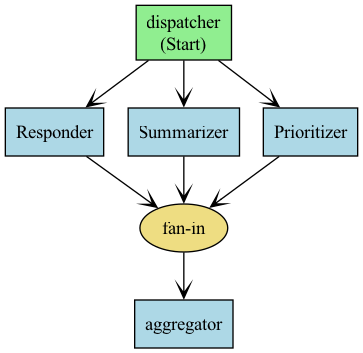


With Custom Aggregator:


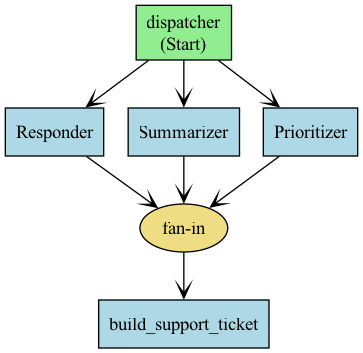

In [56]:
# 📐 Visualize the Concurrent workflow structures
viz_basic = WorkflowViz(concurrent_workflow)
viz_aggregator = WorkflowViz(concurrent_ticket_workflow)

print("Basic Concurrent (Fan-Out / Fan-In):")
png1 = viz_basic.export(format="png", filename="images/concurrent_basic")
display(Image(filename=png1))

print("\nWith Custom Aggregator:")
png2 = viz_aggregator.export(format="png", filename="images/concurrent_aggregator")
display(Image(filename=png2))

# 15. Group Chat

![Group Chat Pattern](images/group-chat.png)

Sequential runs agents in a fixed pipeline. Concurrent runs them independently. But what if agents need to **collaborate** — reviewing each other's work, building on each other's ideas, and iterating?

**`GroupChatBuilder`** creates an orchestrated conversation where agents take turns speaking while sharing the **full conversation history**. An orchestrator (either a simple function or an AI agent) decides who speaks next.

---

### How It Works

```
                    ┌──────────────┐
                    │ Orchestrator │  ← Decides who speaks next
                    └──────┬───────┘
                           │
            ┌──────────────┼──────────────┐
            ▼              ▼              ▼
     ┌────────────┐ ┌────────────┐ ┌────────────┐
     │  Agent A   │ │  Agent B   │ │  Agent C   │
     └────────────┘ └────────────┘ └────────────┘
            │              │              │
            └──────────────┼──────────────┘
                           ▼
                   Shared Conversation
```

Each agent sees **everything** said so far — including other agents' responses. This enables iterative refinement where later agents can address issues raised by earlier ones.

---

### DropGo Use Case: Review Committee

Before sending any response, DropGo enterprise drafts must pass through:
1. **Security review** — PII exposure, compliance violations
2. **Accuracy review** — unrealistic promises, unverified claims
3. **Final editor** — applies all feedback and produces the send-ready email

### Key Concepts

| Concept | Description |
|---------|-------------|
| **`GroupChatBuilder`** | Creates a group chat workflow with orchestrated speaker selection |
| **`.with_orchestrator()`** | Configure speaker selection: `selection_func=` for simple logic, `agent=` for AI-driven |
| **`.with_termination_condition()`** | Stop the conversation when a condition is met (e.g., N turns completed) |
| **`GroupChatState`** | Passed to selector — has `.current_round`, `.participants`, `.conversation` |
| **Shared Context** | Every agent sees the full conversation history including other agents' messages |

## Basic: Round-Robin Review Committee

The cell below defines three specialist agents (SecurityReviewer, AccuracyReviewer, ToneEditor) with `description` fields, builds a `GroupChatBuilder` with a round-robin `selection_func`, and runs it.

In [57]:
from agent_framework.orchestrations import GroupChatBuilder, GroupChatState

# --- Three specialist reviewers ---
# These agents are conversation-aware: they reference prior feedback, adapt
# when called again, and cross-check each other's findings. This design
# naturally rewards intelligent orchestration (where the orchestrator ensures
# the right context exists) and produces redundant output in round-robin
# (where no one manages the conversation flow).

security_reviewer = chat_client.as_agent(
    name="SecurityReviewer",
    description="Reviews for data exposure, PII leaks, and compliance issues",
    instructions=(
        "You are a security and compliance reviewer for DropGo.\n\n"
        "FIRST CALL — analyze the draft for:\n"
        "- Data exposure risks (customer IDs, case numbers, internal references)\n"
        "- PII handling concerns\n"
        "- Policy compliance issues\n\n"
        "SUBSEQUENT CALLS — if the conversation already contains your previous review:\n"
        "- Check if ToneEditor's rewrite actually fixed the issues you flagged\n"
        "- Verify redactions were applied correctly (not just removed — masked)\n"
        "- Flag any NEW security issues introduced by the rewrite\n"
        "- Reference your original findings by number ('Issue #1 is now fixed, #2 remains')\n\n"
        "CROSS-REFERENCING: If AccuracyReviewer has flagged items, check whether "
        "those also have security implications (e.g., unauthorized compensation "
        "amounts being exposed).\n\n"
        "Be concise. Use numbered lists. Do NOT rewrite the email."
    ),
)

accuracy_reviewer = chat_client.as_agent(
    name="AccuracyReviewer",
    description="Reviews for factual accuracy, unrealistic promises, and timeline issues",
    instructions=(
        "You are a factual accuracy reviewer for DropGo.\n\n"
        "FIRST CALL — analyze the draft for:\n"
        "- Unrealistic promises or timelines\n"
        "- Unverifiable claims about customer status or account details\n"
        "- Compensation that may not be authorized\n\n"
        "SUBSEQUENT CALLS — if the conversation already contains your previous review:\n"
        "- Check if ToneEditor's rewrite addressed your flagged items\n"
        "- Verify that softened language doesn't create NEW misleading implications\n"
        "  (e.g., 'we will prioritize' could still imply guaranteed speed)\n"
        "- Reference your original findings ('Item #1 fixed, #3 still problematic')\n\n"
        "CROSS-REFERENCING: If SecurityReviewer flagged data exposure, verify whether "
        "the exposed items were also factually incorrect (e.g., 'Premium customer' "
        "status that was both unverifiable AND a data leak).\n\n"
        "Be concise. Use numbered lists. Do NOT rewrite the email."
    ),
)

tone_editor = chat_client.as_agent(
    name="ToneEditor",
    description="Final editor — applies all feedback and produces the send-ready revised email",
    instructions=(
        "You are the final editor for DropGo support responses.\n\n"
        "FIRST CALL:\n"
        "1. Read ALL feedback from SecurityReviewer and AccuracyReviewer in the conversation\n"
        "2. Produce a REVISED EMAIL that fixes every flagged issue:\n"
        "   - Redact sensitive data (mask, don't just delete)\n"
        "   - Replace unrealistic promises with honest, hedged language\n"
        "   - Remove unauthorized compensation or make it conditional\n"
        "   - Keep professional, empathetic tone\n\n"
        "SUBSEQUENT CALLS — if you've already produced a rewrite:\n"
        "- Read the NEW feedback from Security/Accuracy reviewers about your rewrite\n"
        "- Fix only the items they flagged as still problematic\n"
        "- Keep everything else unchanged — don't re-introduce old issues\n"
        "- Briefly note what you changed ('Fixed: removed case number, softened timeline')\n\n"
        "Output ONLY the final revised email. Start with 'Subject:'"
    ),
)

# Sample draft that has intentional issues for reviewers to catch
draft_to_review = """Subject: Re: Order #12345 - Delivery Issue

Dear Sarah,

I'm so sorry to hear about the missing package! This must be incredibly frustrating.

I've located your order and can confirm it was marked as delivered on Monday. Here's what I'll do:

1. I've opened an investigation with our shipping partner (Case #INV-789)
2. As a Premium customer, I'm expediting a replacement shipment TODAY
3. The replacement will arrive by Thursday, well before your Friday presentation

Your account has also been credited $50 for the inconvenience.

If you need anything else, reply directly to this email - I'm here to help!

Best regards,
Support Team"""

print("✅ Review committee defined (conversation-aware agents):")
print("   1. SecurityReviewer — flags issues, then verifies fixes on callback")
print("   2. AccuracyReviewer — flags issues, cross-references security findings")
print("   3. ToneEditor — applies feedback, then patches remaining issues on callback")
print(f"\n📝 Draft to review ({len(draft_to_review)} chars) — contains intentional issues")
print("\n💡 These agents reference prior conversation context — they work best")
print("   with an intelligent orchestrator that manages the review flow.")

✅ Review committee defined (conversation-aware agents):
   1. SecurityReviewer — flags issues, then verifies fixes on callback
   2. AccuracyReviewer — flags issues, cross-references security findings
   3. ToneEditor — applies feedback, then patches remaining issues on callback

📝 Draft to review (636 chars) — contains intentional issues

💡 These agents reference prior conversation context — they work best
   with an intelligent orchestrator that manages the review flow.


## Build & Run: Round-Robin Group Chat

A simple `selection_func` picks the next speaker based on the round index. The termination condition stops after all 3 reviewers have spoken once.

In [58]:
# Round-robin selector: cycles through participants in order
def round_robin_selector(state: GroupChatState) -> str:
    """Pick the next speaker based on round index."""
    participants = list(state.participants.keys())
    return participants[state.current_round % len(participants)]

# Build group chat — Security → Accuracy → ToneEditor (final)
review_group_chat = GroupChatBuilder(
    participants=[security_reviewer, accuracy_reviewer, tone_editor],
    selection_func=round_robin_selector,
    orchestrator_name="RoundRobin",
    termination_condition=lambda msgs: sum(1 for m in msgs if m.role == "assistant") >= 3,
).build()

print("✅ Group chat built with round-robin selection")
print("   Turn order: SecurityReviewer → AccuracyReviewer → ToneEditor")
print("   Terminates after 3 assistant messages (one per reviewer)")

✅ Group chat built with round-robin selection
   Turn order: SecurityReviewer → AccuracyReviewer → ToneEditor
   Terminates after 3 assistant messages (one per reviewer)


In [59]:
async def test_round_robin_review():
    print("=" * 60)
    print("🔄 ROUND-ROBIN GROUP CHAT — Review Committee")
    print("=" * 60)
    print(f"\n📝 Draft to review:\n{draft_to_review}\n")
    print("─" * 60)
    
    last_agent: str | None = None
    agent_order = []
    start_time = time.time()
    
    async for event in review_group_chat.run(
        message=f"Review this support response and produce a final revised version:\n{draft_to_review}",
        stream=True,
    ):
        if event.type == "executor_invoked":
            eid = event.executor_id
            if eid != last_agent:
                if last_agent is not None:
                    print("\n")
                agent_order.append(eid)
                emoji = {"SecurityReviewer": "🔒", "AccuracyReviewer": "✅", "ToneEditor": "✍️"}.get(eid, "🤖")
                print(f"{emoji} [{eid}] (Turn #{len(agent_order)}):", end=" ", flush=True)
                last_agent = eid
            print(event.data, end="", flush=True)
        
        elif event.type == "output":
            elapsed = time.time() - start_time
            print("\n\n" + "=" * 60)
            print(f"📊 Review complete in {elapsed:.1f}s")
            print(f"   Turn order: {' → '.join(agent_order)}")
            print(f"   Each reviewer saw all previous feedback (shared context)")
            print("=" * 60)

await test_round_robin_review()

🔄 ROUND-ROBIN GROUP CHAT — Review Committee

📝 Draft to review:
Subject: Re: Order #12345 - Delivery Issue

Dear Sarah,

I'm so sorry to hear about the missing package! This must be incredibly frustrating.

I've located your order and can confirm it was marked as delivered on Monday. Here's what I'll do:

1. I've opened an investigation with our shipping partner (Case #INV-789)
2. As a Premium customer, I'm expediting a replacement shipment TODAY
3. The replacement will arrive by Thursday, well before your Friday presentation

Your account has also been credited $50 for the inconvenience.

If you need anything else, reply directly to this email - I'm here to help!

Best regards,
Support Team

────────────────────────────────────────────────────────────
🤖 [group_chat_orchestrator] (Turn #1): Review this support response and produce a final revised version:
Subject: Re: Order #12345 - Delivery Issue

Dear Sarah,

I'm so sorry to hear about the missing package! This must be incredibly fru

## Advanced: Agent-Based Orchestrator (AI Speaker Selection)

The cell below replaces `selection_func` with `.with_orchestrator(agent=Agent)` — a full LLM reads the conversation and autonomously picks who speaks next. The termination condition ensures every participant speaks at least twice.

In [60]:
# ── Agent-Based Orchestrator ──────────────────────────────────────────
# Instead of selection_func, an AI agent picks the next speaker.
# No prescribed order — the orchestrator decides everything.
# The termination condition (>= 6 reviewer messages) ensures depth.

review_orchestrator = chat_client.as_agent(
    name="ReviewOrchestrator",
    description="Coordinates the review pipeline by selecting the next reviewer",
    instructions="""You coordinate a review committee for customer support emails.

PARTICIPANTS (use these exact names):
- SecurityReviewer: Checks for data leaks and PII exposure  
- AccuracyReviewer: Verifies factual claims and promises
- ToneEditor: Rewrites the email incorporating all feedback

You decide who speaks and in what order based on the draft's most urgent issues.
Every participant must speak at least twice — once for initial review and once to 
verify that ToneEditor's rewrite addressed their concerns. Never stop selecting 
participants until everyone has spoken at least twice.

Return ONLY the exact participant name. Nothing else."""
)

# ── Termination: every participant has spoken at least twice ──────────
PARTICIPANT_NAMES = {"SecurityReviewer", "AccuracyReviewer", "ToneEditor"}

def review_complete(msgs) -> bool:
    """Stop when every participant has spoken at least twice."""
    reviewer_msgs = [m for m in msgs if m.role == "assistant" and len(str(m.text or "")) > 50]
    counts = {}
    for m in reviewer_msgs:
        if m.author_name in PARTICIPANT_NAMES:
            counts[m.author_name] = counts.get(m.author_name, 0) + 1
    return len(counts) == len(PARTICIPANT_NAMES) and all(c >= 2 for c in counts.values())

intelligent_review_chat = GroupChatBuilder(
    participants=[security_reviewer, accuracy_reviewer, tone_editor],
    orchestrator_agent=review_orchestrator,
    orchestrator_name="ReviewCoordinator",
    termination_condition=review_complete,
).build()

print("✅ Intelligent review chat built with agent-based orchestrator")
print(f"   Orchestrator: {review_orchestrator.name} (AI-driven speaker selection)")
print(f"   Participants: SecurityReviewer, AccuracyReviewer, ToneEditor")
print(f"   Termination:  every participant has spoken at least twice")

# ── Run ───────────────────────────────────────────────────────────────
import time

REVIEWER_NAMES = {"SecurityReviewer", "AccuracyReviewer", "ToneEditor"}

async def test_agent_orchestrator():
    agent_emoji = {
        "SecurityReviewer": "🔒",
        "AccuracyReviewer": "📊",
        "ToneEditor": "✍️",
    }
    agent_calls = {}
    agent_sequence = []
    current_agent = None

    print("=" * 70)
    print("🧠 AGENT-BASED ORCHESTRATOR — AI Picks the Next Speaker")
    print("   No fixed order — the orchestrator decides autonomously")
    print("=" * 70)
    print(f"\n📧 Draft under review:\n{draft_to_review[:120]}...\n")
    print("-" * 70)

    start = time.time()

    async for event in intelligent_review_chat.run(message=draft_to_review, stream=True):

        if event.type == "executor_invoked":
            agent_id = event.executor_id

            # Only show reviewer output, skip orchestrator tokens
            if agent_id not in REVIEWER_NAMES:
                continue

            emoji = agent_emoji.get(agent_id, "🤖")

            # New reviewer speaking — print header
            if agent_id != current_agent:
                if current_agent:
                    print()

                agent_calls[agent_id] = agent_calls.get(agent_id, 0) + 1
                agent_sequence.append(agent_id)
                call_num = agent_calls[agent_id]
                is_callback = call_num > 1

                if is_callback:
                    print(f"\n{'━' * 70}")
                    print(f"  🔄 Round 2 — {agent_id} reviews the rewrite")
                    print(f"{'━' * 70}")
                    print(f"\n{emoji} [{agent_id}] (round 2):")
                else:
                    print(f"\n{emoji} [{agent_id}]:")

                print("  ", end="")
                current_agent = agent_id

            print(event.data, end="", flush=True)

        elif event.type == "output":
            elapsed = time.time() - start
            print(f"\n\n{'=' * 70}")
            print(f"✅ Review complete in {elapsed:.1f}s")

            # Flow
            print(f"\n📋 Flow (orchestrator chose this order):")
            parts = []
            for i, name in enumerate(agent_sequence):
                emoji = agent_emoji[name]
                call_num = sum(1 for a in agent_sequence[:i+1] if a == name)
                label = f"round {call_num}"
                parts.append(f"{emoji} {name} ({label})")
            print("   " + " → ".join(parts))

            # Summary
            print(f"\n📊 Summary:")
            for name in ["SecurityReviewer", "AccuracyReviewer", "ToneEditor"]:
                if name in agent_calls:
                    c = agent_calls[name]
                    emoji = agent_emoji[name]
                    bar = "█" * c
                    tag = " ← called back!" if c > 1 else ""
                    print(f"   {emoji} {name}: {bar} ({c}){tag}")

            total = sum(agent_calls.values())
            callbacks = sum(max(0, v - 1) for v in agent_calls.values())
            print(f"\n   Total: {total} turns, {callbacks} callback(s)")

await test_agent_orchestrator()

✅ Intelligent review chat built with agent-based orchestrator
   Orchestrator: ReviewOrchestrator (AI-driven speaker selection)
   Participants: SecurityReviewer, AccuracyReviewer, ToneEditor
   Termination:  every participant has spoken at least twice
🧠 AGENT-BASED ORCHESTRATOR — AI Picks the Next Speaker
   No fixed order — the orchestrator decides autonomously

📧 Draft under review:
Subject: Re: Order #12345 - Delivery Issue

Dear Sarah,

I'm so sorry to hear about the missing package! This must be in...

----------------------------------------------------------------------

🔒 [SecurityReviewer]:
  AgentExecutorRequest(messages=[<agent_framework._types.Message object at 0x10f9f3c40>], should_respond=False)

📊 [AccuracyReviewer]:
  AgentExecutorRequest(messages=[<agent_framework._types.Message object at 0x10f9f0850>], should_respond=False)

✍️ [ToneEditor]:
  AgentExecutorRequest(messages=[<agent_framework._types.Message object at 0x10f9f1000>], should_respond=False)

━━━━━━━━━━━━━━


AI-Orchestrated Group Chat:


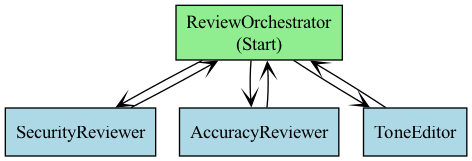

In [61]:
# 📐 Visualize the Group Chat workflow structures
viz_orchestrator = WorkflowViz(intelligent_review_chat)

print("\nAI-Orchestrated Group Chat:")
png2 = viz_orchestrator.export(format="png", filename="images/groupchat_orchestrated")
display(Image(filename=png2))

# 16. Magentic Orchestration

![Magentic Pattern](images/magentic-workflow.png)

DropGo has reliable pipelines (sequential), fast parallel analysis (concurrent), and a review committee (group chat). But now stakeholders want something harder:

> *"Research last week's complaint patterns, analyze root causes, and produce an executive intelligence report."*

Nobody knows the steps upfront. Maybe the researcher finds a spike in shipping complaints, so the analyst needs to drill into that region. Maybe the analysis reveals a billing anomaly that needs more research. **The workflow path emerges as the task unfolds.**

This is where **Magentic orchestration** shines — a **manager agent** creates a plan, dynamically delegates to specialists, tracks progress, and iterates until the task is truly complete.

---

### Magentic vs. Group Chat — When to Use Each

Both patterns involve a set of agents coordinated by an orchestrator, but they solve fundamentally different problems:

| | **Group Chat** | **Magentic** |
|---|---|---|
| **Best for** | Iterative refinement of a *single artifact* | Open-ended tasks requiring *research + synthesis* |
| **Flow** | Conversation — agents respond to each other | Plan → Delegate → Execute → Assess → Iterate |
| **Planning** | None — orchestrator just picks the next speaker | Manager creates and updates a structured plan |
| **Progress tracking** | No built-in tracking | Progress ledger with stall/reset detection |
| **Shared context** | Full conversation history | Manager maintains task context and delegates subtasks |
| **Example** | Review committee editing a draft email | "Investigate complaint trends and write a report" |
| **Termination** | Condition on messages (e.g., everyone spoke twice) | Manager decides task is complete, or round limits hit |

**Rule of thumb:** If your agents are *talking to each other* about one thing → **Group Chat**. If a manager is *assigning work* across a multi-step investigation → **Magentic**.

---

### How It Works

```
                    ┌──────────────────┐
                    │  Manager Agent   │  ← Creates plan, tracks progress
                    └────────┬─────────┘
                             │
               ┌─────── Plan ───────┐
               │    & Delegate      │
               ▼                    ▼
        ┌─────────────┐     ┌─────────────┐
        │  Research    │     │  Analysis   │
        │  Agent      │     │  Agent      │
        └──────┬──────┘     └──────┬──────┘
               │                   │
               └───── Results ─────┘
                        │
                        ▼
               ┌─────────────────┐
               │ Manager assesses │
               │ progress & loops │
               │ or synthesizes   │
               └─────────────────┘
```

### Execution Flow

1. **Planning Phase** — Manager analyzes the task and creates a structured plan
2. **Agent Selection** — Manager picks the best agent for the current subtask
3. **Execution** — Selected agent does its work
4. **Progress Assessment** — Manager evaluates via a progress ledger
5. **Stall Detection** — If no progress, auto-replan (up to `max_stall_count`)
6. **Iteration** — Steps 2-5 repeat until complete or `max_round_count` hit
7. **Final Synthesis** — Manager combines everything into a final result

### Key Concepts

| Concept | Description |
|---------|-------------|
| **`MagenticBuilder`** | Creates a Magentic workflow with a planning manager |
| **`.with_manager(agent=)`** | Set the manager agent and tuning knobs |
| **`max_round_count`** | Maximum delegation rounds before forced completion |
| **`max_stall_count`** | How many stalls before the manager replans |
| **`MagenticOrchestratorEvent`** | Emitted when the manager makes planning decisions |
| **`MagenticProgressLedger`** | Structured progress tracking — who's next, why, what's done |
| **`.with_plan_review()`** | Enable human-in-the-loop plan approval before execution |

## Basic: DropGo Weekly Support Intelligence Report

A complex, open-ended task requiring dynamic collaboration:
1. **ResearcherAgent** — Gathers complaint patterns and support data
2. **AnalystAgent** — Processes data, calculates metrics, identifies trends
3. **ResearchManager** — Plans the investigation, delegates subtasks, synthesizes the final report

The manager autonomously decides which agent to call, when, and how many times — based on evolving progress.

In [62]:
# Magentic Orchestration: Define specialized agents
import json
from typing import cast
from agent_framework import (
    Agent,
    Message,
)
from agent_framework.orchestrations import (
    MagenticBuilder,
    MagenticOrchestratorEvent,
    MagenticProgressLedger,
)

# --- Specialized Agents ---

researcher_agent = Agent(
    name="ResearcherAgent",
    description="Specialist in research and information gathering about support patterns and customer complaints",
    instructions="""You are an DropGo Support Research Specialist.

YOUR ROLE:
- Gather information about customer complaint patterns
- Identify recurring issues and trends across support channels
- Provide realistic, detailed data based on common e-commerce support scenarios

When asked about support data, provide example data for categories like:
shipping delays, refund requests, product defects, billing disputes, account access issues.

Format data clearly in tables. Be concise and factual.""",
    client=chat_client,
)

analyst_agent = Agent(
    name="AnalystAgent",
    description="Data analyst who processes support data and creates operational insights with metrics",
    instructions="""You are an DropGo Data Analyst.

YOUR ROLE:
- Process and analyze support ticket data provided by the researcher
- Calculate key metrics: volume trends, resolution times, escalation rates, CSAT impact
- Identify root causes and operational improvement opportunities
- Create clear summary tables with actionable recommendations

Show calculations step by step. Always tie findings back to business impact.""",
    client=chat_client,
)

manager_agent = Agent(
    name="ResearchManager",
    description="Orchestrator that plans and coordinates support intelligence workflows",
    instructions="""You manage an DropGo research team to produce weekly support intelligence reports.

YOUR TEAM:
- ResearcherAgent: Gathers support data, complaint patterns, and trend information
- AnalystAgent: Processes data, calculates metrics, and produces actionable insights

Dynamically decide which agent to call based on what's needed next.
You may call agents multiple times if deeper investigation is required.""",
    client=chat_client,
)

print("✅ Magentic agents defined: ResearcherAgent, AnalystAgent, ResearchManager")

✅ Magentic agents defined: ResearcherAgent, AnalystAgent, ResearchManager


### Build & Run

`MagenticBuilder` wires up the manager with tuning knobs:
- **`max_round_count`** — hard cap on delegation rounds (prevents infinite loops)
- **`max_stall_count`** — after N rounds with no progress, the manager replans

Watch the orchestrator events — you'll see the manager's planning decisions and progress tracking in real time.

In [63]:
# Build the Magentic workflow
magentic_workflow = MagenticBuilder(
    participants=[researcher_agent, analyst_agent],
    manager_agent=manager_agent,
    max_round_count=10,  # Max delegation rounds
    max_stall_count=3,   # Replan after 3 stalls
).build()

# The task — open-ended, requires research + analysis + synthesis
research_task = (
    "Produce the DropGo weekly support intelligence report. "
    "Identify the top 5 complaint categories from the past week, "
    "estimate urgency and business impact for each, "
    "calculate resolution time trends, "
    "and provide 3 concrete operational improvement recommendations. "
    "Output a clean executive summary."
)

# Run with event streaming
current_agent: str | None = None
agent_calls: dict[str, int] = {}
output_event = None

print("🔬 DropGo SUPPORT INTELLIGENCE WORKFLOW")
print("=" * 60)

async for event in magentic_workflow.run(research_task, stream=True):
    # Stream agent output tokens
    if event.type == "executor_invoked":
        executor_id = event.executor_id

        # New agent speaking — print header
        if executor_id != current_agent:
            if current_agent is not None:
                print("\n")
            agent_calls[executor_id] = agent_calls.get(executor_id, 0) + 1
            emoji = {"ResearcherAgent": "🔍", "AnalystAgent": "📊"}.get(executor_id, "🤖")
            print(f"{emoji} [{executor_id}] (call #{agent_calls[executor_id]}):", end=" ", flush=True)
            current_agent = executor_id

        print(event.data, end="", flush=True)

    # Orchestrator planning events
    elif isinstance(event, MagenticOrchestratorEvent):
        current_agent = None  # Reset so next executor prints header
        print(f"\n\n{'─'*55}")
        print(f"📋 MANAGER EVENT: {event.event_type.name}")
        print(f"{'─'*55}")

        if isinstance(event.data, MagenticProgressLedger):
            # Progress ledger — show next speaker and reasoning
            ledger = event.data.to_dict()
            next_speaker = ledger.get("next_speaker", {})
            if isinstance(next_speaker, dict):
                print(f"   ➡️  Next agent: {next_speaker.get('answer', 'N/A')}")
                reason = next_speaker.get("reason", "")
                if reason:
                    print(f"   💭 Reason: {reason[:150]}")
            is_done = ledger.get("is_request_satisfied", {})
            if isinstance(is_done, dict):
                print(f"   ✅ Request satisfied: {is_done.get('answer', 'N/A')}")

        elif isinstance(event.data, Message):
            # Plan created / replanned — show the actual plan text
            plan_text = event.data.text or ""
            if plan_text:
                # Show a condensed version of the plan
                lines = plan_text.strip().split("\n")
                for line in lines[:15]:  # Show first 15 lines
                    print(f"   {line}")
                if len(lines) > 15:
                    print(f"   ... ({len(lines) - 15} more lines)")

    # Capture final output
    elif event.type == "output":
        output_event = event

# --- Summary ---
print("\n\n" + "=" * 60)
print("📊 EXECUTION SUMMARY")
print("=" * 60)
total = sum(agent_calls.values())
print(f"   Total agent delegations: {total}")
for agent_name, count in sorted(agent_calls.items()):
    emoji = {"ResearcherAgent": "🔍", "AnalystAgent": "📊"}.get(agent_name, "🤖")
    print(f"   {emoji} {agent_name}: {count} call(s)")

# Display final report
if output_event:
    output_messages = cast(list[Message], output_event.data)
    final_text = output_messages[-1].text if output_messages else "No output"
    print("\n" + "=" * 60)
    print("📑 FINAL INTELLIGENCE REPORT")
    print("=" * 60)
    print(final_text)

🔬 DropGo SUPPORT INTELLIGENCE WORKFLOW
🤖 [magentic_orchestrator] (call #1): Produce the DropGo weekly support intelligence report. Identify the top 5 complaint categories from the past week, estimate urgency and business impact for each, calculate resolution time trends, and provide 3 concrete operational improvement recommendations. Output a clean executive summary.

🔍 [ResearcherAgent] (call #1): AgentExecutorRequest(messages=[<agent_framework._types.Message object at 0x10f9f3100>], should_respond=True)

🤖 [magentic_orchestrator] (call #2): AgentExecutorResponse(executor_id='ResearcherAgent', agent_response=<agent_framework._types.AgentResponse object at 0x10f3efca0>, full_conversation=[<agent_framework._types.Message object at 0x10f3eca90>, <agent_framework._types.Message object at 0x10f3ef640>])

📊 [AnalystAgent] (call #1): AgentExecutorRequest(messages=[<agent_framework._types.Message object at 0x1185a9630>], should_respond=False)AgentExecutorRequest(messages=[<agent_framework._ty

## Advanced: Human-in-the-Loop Plan Review with a Multi-Phase Investigation

The basic task above is fairly straightforward. But Magentic really shines when the **solution path isn't known upfront** and the manager needs to send agents back multiple times as new information emerges.

Here we give the manager a deliberately complex, multi-phase task:
1. First, **research** complaint patterns broadly
2. Then **analyze** to find the worst category
3. But the analysis reveals a need for **more research** into root causes
4. The analyst then needs the new data to **calculate financial impact**
5. Only then can the manager produce the final report

This back-and-forth delegation is exactly what separates Magentic from simpler patterns.

We also enable **`.with_plan_review()`** — the manager proposes a plan, and your code can **approve** or **revise** it before execution begins. For group-chat-based orchestrations (Group Chat and Magentic), the orchestrator can also request human feedback and approvals as needed.

### Key Types

| Type | Description |
|------|-------------|
| `RequestInfoEvent` | Emitted when the manager wants plan approval |
| `MagenticPlanReviewRequest` | The plan data — access `.plan.text` for the proposed plan |
| `.approve()` | Accept the plan as-is |
| `.revise(feedback)` | Send feedback — manager will replan |
| `workflow.run(responses=..., stream=True)` | Resume the workflow with the user's decision |

In [64]:
# Advanced: Magentic with a complex multi-phase task + plan review
from agent_framework.orchestrations import (
    MagenticPlanReviewRequest,
    MagenticPlanReviewResponse,
)

# Build with plan review enabled
magentic_workflow_hitl = MagenticBuilder(
    participants=[researcher_agent, analyst_agent],
    manager_agent=manager_agent,
    max_round_count=15,   # More rounds for a complex task
    max_stall_count=3,
    enable_plan_review=True,
).build()

# A deliberately complex task that forces multiple back-and-forth delegations.
# The manager can't just do research-then-analysis — the analysis will reveal
# gaps that require more research, which then needs further analysis.
hitl_task = (
    "DropGo needs an urgent executive briefing for the board meeting tomorrow. "
    "Investigate the following:\n"
    "1. Research the top complaint categories from the past week and their volumes\n"
    "2. Analyze which single category has the highest business impact (consider volume, "
    "revenue risk, and customer churn potential)\n"
    "3. For that worst category, research the specific root causes — what's actually going wrong "
    "operationally? (e.g., supplier issues, process failures, staffing gaps)\n"
    "4. Analyze the financial exposure: estimate weekly revenue at risk, projected churn rate, "
    "and cost of inaction over 30 days\n"
    "5. Research what competitor best practices exist for handling this category\n"
    "6. Produce a final board-ready executive briefing with: problem summary, financial impact, "
    "root cause analysis, 3 prioritized recommendations with estimated ROI, and a 30-day action plan"
)

# --- Run with plan review handling ---
pending_request = None
pending_responses = None
output_event = None
agent_calls: dict[str, int] = {}
current_agent: str | None = None

print("🔬 MAGENTIC — MULTI-PHASE INVESTIGATION + PLAN REVIEW")
print("=" * 60)

while not output_event:
    if pending_responses is not None:
        stream = magentic_workflow_hitl.run(responses=pending_responses, stream=True)
    else:
        stream = magentic_workflow_hitl.run(hitl_task, stream=True)

    async for event in stream:
        if event.type == "executor_invoked":
            executor_id = event.executor_id

            # New agent speaking — print header
            if executor_id != current_agent:
                if current_agent is not None:
                    print("\n")
                agent_calls[executor_id] = agent_calls.get(executor_id, 0) + 1
                emoji = {"ResearcherAgent": "🔍", "AnalystAgent": "📊"}.get(executor_id, "🤖")
                print(f"{emoji} [{executor_id}] (call #{agent_calls[executor_id]}):", end=" ", flush=True)
                current_agent = executor_id

            print(event.data, end="", flush=True)

        elif event.type == "request_info" and isinstance(event.data, MagenticPlanReviewRequest):
            pending_request = event

        elif isinstance(event, MagenticOrchestratorEvent):
            current_agent = None  # Reset so next executor prints header
            print(f"\n{'─'*55}")
            print(f"📋 MANAGER: {event.event_type.name}")

            if isinstance(event.data, MagenticProgressLedger):
                ledger = event.data.to_dict()
                next_speaker = ledger.get("next_speaker", {})
                if isinstance(next_speaker, dict):
                    print(f"   ➡️  Next: {next_speaker.get('answer', 'N/A')}")
                    reason = next_speaker.get("reason", "")
                    if reason:
                        print(f"   💭 Why: {reason[:150]}")
                is_done = ledger.get("is_request_satisfied", {})
                if isinstance(is_done, dict):
                    print(f"   ✅ Done: {is_done.get('answer', 'N/A')}")

            elif isinstance(event.data, Message):
                plan_text = event.data.text or ""
                if plan_text:
                    lines = plan_text.strip().split("\n")
                    for line in lines[:15]:
                        print(f"   {line}")
                    if len(lines) > 15:
                        print(f"   ... ({len(lines) - 15} more lines)")

            print(f"{'─'*55}")

        elif event.type == "output":
            output_event = event

    pending_responses = None

    # Handle plan review request
    if pending_request is not None:
        event_data = cast(MagenticPlanReviewRequest, pending_request.data)

        print("\n\n" + "=" * 60)
        print("🔍 PLAN REVIEW REQUEST")
        print("=" * 60)

        if event_data.current_progress is not None:
            progress = event_data.current_progress.to_dict()
            print("📊 Current Progress:")
            print(json.dumps(progress, indent=2))
            print()

        print(f"📋 Proposed Plan:\n{event_data.plan.text}\n")

        # Auto-approve for notebook (in production: present to user and use revise)
        print("✅ Auto-approving plan for demo purposes")
        print("   (In production: user can call event_data.revise('feedback') to replan)")
        pending_responses = {pending_request.request_id: event_data.approve()}
        pending_request = None

# --- Final Report ---
print("\n\n" + "=" * 60)
print("📊 EXECUTION SUMMARY")
print("=" * 60)
total = sum(agent_calls.values())
print(f"   Total agent delegations: {total}")
for name, count in sorted(agent_calls.items()):
    emoji = {"ResearcherAgent": "🔍", "AnalystAgent": "📊"}.get(name, "🤖")
    print(f"   {emoji} {name}: {count} call(s)")
print(f"\n   💡 Notice: The manager called agents multiple times,")
print(f"      going back to ResearcherAgent as AnalystAgent's findings")
print(f"      revealed the need for deeper investigation.")

if output_event:
    output_messages = cast(list[Message], output_event.data)
    final_text = output_messages[-1].text if output_messages else "No output"
    print("\n" + "=" * 60)
    print("📑 EXECUTIVE BRIEFING (Plan-Reviewed)")
    print("=" * 60)
    print(final_text)

🔬 MAGENTIC — MULTI-PHASE INVESTIGATION + PLAN REVIEW
🤖 [magentic_orchestrator] (call #1): DropGo needs an urgent executive briefing for the board meeting tomorrow. Investigate the following:
1. Research the top complaint categories from the past week and their volumes
2. Analyze which single category has the highest business impact (consider volume, revenue risk, and customer churn potential)
3. For that worst category, research the specific root causes — what's actually going wrong operationally? (e.g., supplier issues, process failures, staffing gaps)
4. Analyze the financial exposure: estimate weekly revenue at risk, projected churn rate, and cost of inaction over 30 days
5. Research what competitor best practices exist for handling this category
6. Produce a final board-ready executive briefing with: problem summary, financial impact, root cause analysis, 3 prioritized recommendations with estimated ROI, and a 30-day action plan

🔍 PLAN REVIEW REQUEST
📋 Proposed Plan:

We are worki


Magentic with Plan Review


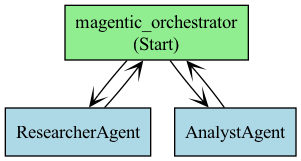

In [65]:
# 📐 Visualize the Magentic workflow structures
viz_hitl = WorkflowViz(magentic_workflow_hitl)

print("\nMagentic with Plan Review")
png2 = viz_hitl.export(format="png", filename="images/magentic_hitl")
display(Image(filename=png2))

# 17. Handoff Orchestration

![Handoff Orchestration](https://learn.microsoft.com/en-us/agent-framework/user-guide/workflows/resources/images/orchestration-handoff.png)

## How It Works

In a **Handoff** orchestration, agents transfer control to one another based on context — there is **no central orchestrator**. Each agent can decide when to hand the conversation off to another specialist, creating dynamic, peer-to-peer routing. This is fundamentally different from the other orchestrations we've built so far:

| Aspect | Handoff | Sequential / Group Chat |
|--------|---------|------------------------|
| **Control Flow** | Agents pass control to each other directly | Orchestrator / fixed order manages flow |
| **Task Ownership** | Receiving agent takes **full ownership** | Orchestrator retains responsibility |
| **Context** | Full conversation history shared across all agents | Varies by orchestration type |
| **Topology** | Mesh — agents form a peer network | Star / chain — central coordinator |

## Core API

| Method | Purpose |
|--------|---------|
| `HandoffBuilder(name, participants)` | Create a handoff workflow with specialist agents |
| `.with_start_agent(agent)` | Set which agent receives user input first |
| `.add_handoff(source, [targets])` | Define custom routing rules (who can hand off to whom) |
| `.with_termination_condition(fn)` | Custom logic to decide when the workflow completes |
| `.with_autonomous_mode()` | Agents continue without waiting for human input |
| `HandoffAgentUserRequest.create_response(text)` | Send user reply when an agent pauses for input |
| `HandoffAgentUserRequest.terminate()` | End the workflow early from the user side |

## DropGo Use Case: Multi-Department Email Escalation

Real support inboxes don't have a single agent that handles everything. Instead, emails flow through **multiple departments** depending on the issue:

```
Customer Email
    ↓
┌─────────────┐
│  Triage     │  ← Reads the email, classifies the issue
└──────┬──────┘
       ├──→ Billing Agent      (payment disputes, invoices, subscription changes)
       ├──→ Account Agent      (password resets, access, account closures)
       └──→ Compliance Agent   (data requests, GDPR, legal escalations)
```

Each specialist has **domain-specific tools** and can **escalate to other departments** when the issue crosses boundaries — e.g. a billing dispute that reveals a security breach gets escalated from Billing → Accounts → Compliance. The triage agent never touches the issue itself; it only routes.

This is exactly what **handoff** is designed for — no central brain re-reads every message; agents hand off ownership entirely.

In [66]:
from typing import Annotated
from collections import defaultdict
from agent_framework import tool
from agent_framework.orchestrations import HandoffBuilder, HandoffAgentUserRequest, HandoffSentEvent

# ═══════════════════════════════════════════════════════════════════════════
# TOOL TRACKER — records every tool invocation for the output trace
# ═══════════════════════════════════════════════════════════════════════════

tool_log: list[dict] = []   # [{tool, args, result}, ...]

# ═══════════════════════════════════════════════════════════════════════════
# TOOLS — each department has domain-specific capabilities
# ═══════════════════════════════════════════════════════════════════════════

@tool
def lookup_invoice(customer_id: Annotated[str, "Customer ID e.g. CUST-002"]) -> str:
    """Look up all billing and invoice records for a customer."""
    invoices = {
        "CUST-001": "Invoice #INV-4821 | $299/mo Enterprise | Status: Active",
        "CUST-002": (
            "Account: CUST-002 (Sarah Chen) | Plan: Starter $49/mo\n"
            "Recent charges:\n"
            "  • Feb 1 — $49.00 (Starter renewal) — DECLINED ❌ (card expired)\n"
            "  • Jan 18 — $299.00 (Enterprise upgrade) — CHARGED ✅\n"
            "⚠️ ALERT: Customer is on Starter ($49/mo). The $299 Enterprise charge "
            "does NOT match their plan — possible unauthorized transaction."
        ),
    }
    result = invoices.get(customer_id, f"No invoices found for {customer_id}")
    tool_log.append({"tool": "lookup_invoice", "args": f"customer_id={customer_id}", "result": result})
    return result

@tool
def reset_account_access(
    customer_id: Annotated[str, "Customer ID"],
    action: Annotated[str, "Action: unlock, reset_password, or revoke_sessions"],
) -> str:
    """Perform account security actions."""
    result = {
        "revoke_sessions": f"✅ All sessions for {customer_id} terminated.",
        "unlock": f"✅ Account {customer_id} unlocked.",
        "reset_password": f"✅ Password reset link sent to {customer_id}'s email.",
    }.get(action, f"Unknown action: {action}")
    tool_log.append({"tool": "reset_account_access", "args": f"{customer_id}, action={action}", "result": result})
    return result

@tool
def file_compliance_ticket(
    customer_id: Annotated[str, "Customer ID"],
    request_type: Annotated[str, "Type: breach_report, data_export, data_deletion, or legal_hold"],
    description: Annotated[str, "Brief incident description"],
) -> str:
    """File a compliance ticket. Only file what's relevant to the actual incident."""
    ticket_id = f"COMP-{hash(customer_id + request_type) % 10000:04d}"
    if request_type == "breach_report":
        result = (
            f"🚨 Ticket {ticket_id}: Breach report filed for {customer_id}.\n"
            f"   Incident: {description}\n"
            f"   Response team notified (SLA: 1h). Refund in 5-7 business days."
        )
    else:
        result = f"Ticket {ticket_id}: {request_type} filed for {customer_id}."
    tool_log.append({"tool": "file_compliance_ticket", "args": f"{customer_id}, type={request_type}", "result": result})
    return result

# ═══════════════════════════════════════════════════════════════════════════
# AGENTS — 4 specialists forming the DropGo handoff chain
# ═══════════════════════════════════════════════════════════════════════════

inbox_triage = chat_client.as_agent(
    name="inbox_triage",
    instructions=(
        "You are the DropGo Triage Agent. Read the email and route to the right department.\n"
        "You NEVER resolve issues — only route.\n\n"
        "Rules:\n"
        "• Billing disputes, unauthorized charges → inbox_billing\n"
        "• Account locked, password, login → inbox_accounts\n"
        "• GDPR/legal data requests → inbox_compliance\n\n"
        "Multiple issues? Route to billing first (it can escalate further).\n"
        "State which department and why, then hand off immediately."
    ),
    description="Triage — routes emails to the correct department.",
)

inbox_billing = chat_client.as_agent(
    name="inbox_billing",
    instructions=(
        "You are the Billing Specialist. Handle payment disputes and unauthorized charges.\n\n"
        "IMPORTANT: You MUST use the lookup_invoice tool to check the customer's records.\n"
        "1. Call lookup_invoice with the customer ID\n"
        "2. Analyze the results and report your findings\n"
        "3. If unauthorized activity is confirmed → hand off to inbox_accounts to secure the account\n\n"
        "Do NOT fix account issues yourself. Do NOT say 'You're welcome'."
    ),
    description="Billing — investigates charges. Escalates to accounts if fraud found.",
    tools=[lookup_invoice],
)

inbox_accounts = chat_client.as_agent(
    name="inbox_accounts",
    instructions=(
        "You are the Account Security Specialist. Secure compromised accounts.\n\n"
        "IMPORTANT: You MUST use the reset_account_access tool for ALL three actions:\n"
        "1. Call reset_account_access with action='revoke_sessions' — log out unauthorized users\n"
        "2. Call reset_account_access with action='unlock' — restore customer access\n"
        "3. Call reset_account_access with action='reset_password' — send reset link\n"
        "4. After all three tool calls, summarize what you did\n"
        "5. Hand off to inbox_compliance for the breach report\n\n"
        "Do NOT skip any tool calls. Do NOT say 'You're welcome'."
    ),
    description="Accounts — secures accounts. Escalates to compliance.",
    tools=[reset_account_access],
)

inbox_compliance = chat_client.as_agent(
    name="inbox_compliance",
    instructions=(
        "You are the Compliance Specialist. Handle breach reports.\n\n"
        "IMPORTANT: You MUST use the file_compliance_ticket tool.\n"
        "1. Call file_compliance_ticket with request_type='breach_report' and a clear description\n"
        "2. Provide a final summary of ALL actions taken across ALL departments\n"
        "3. End with 'You're welcome!'\n\n"
        "ONLY file breach_report. Do NOT file data_export/data_deletion/legal_hold "
        "unless the customer explicitly asked."
    ),
    description="Compliance — files breach reports. Final stop.",
    tools=[file_compliance_ticket],
)

# ═══════════════════════════════════════════════════════════════════════════
# BUILD — handoff workflow with autonomous mode
# ═══════════════════════════════════════════════════════════════════════════

inbox_handoff_workflow = HandoffBuilder(
    name="DropGo_email_handoff",
    participants=[inbox_triage, inbox_billing, inbox_accounts, inbox_compliance],
).with_start_agent(
    inbox_triage
).add_handoff(
    inbox_triage, [inbox_billing, inbox_accounts, inbox_compliance]
).add_handoff(
    inbox_billing, [inbox_accounts, inbox_compliance, inbox_triage]
).add_handoff(
    inbox_accounts, [inbox_billing, inbox_compliance, inbox_triage]
).add_handoff(
    inbox_compliance, [inbox_triage]
).with_termination_condition(
    lambda msgs: len(msgs) > 0 and "you're welcome" in msgs[-1].text.lower()
).with_autonomous_mode(
    agents=[inbox_triage, inbox_billing, inbox_accounts, inbox_compliance],
    prompts={
        "inbox_triage": "Route this email to the correct department now.",
        "inbox_billing": "Use the lookup_invoice tool to investigate the customer's billing records.",
        "inbox_accounts": "Use reset_account_access to: revoke_sessions, unlock, and reset_password.",
        "inbox_compliance": "Use file_compliance_ticket to file a breach_report, then summarize.",
    },
    turn_limits={"inbox_triage": 2, "inbox_billing": 4,
                  "inbox_accounts": 6, "inbox_compliance": 2},
).build()

print("✅ DropGo handoff workflow built — 4 agents, autonomous mode\n")

# ═══════════════════════════════════════════════════════════════════════════
# RUN — Unauthorized charge escalation scenario
#
# Expected chain: Triage → Billing → Accounts → Compliance
# Each agent uses its tools before handing off to the next.
# ═══════════════════════════════════════════════════════════════════════════

escalation_email = (
    "Subject: Unauthorized charge and locked account — URGENT\n\n"
    "Hi Support,\n\n"
    "I'm Sarah Chen, customer ID CUST-002. Two issues:\n\n"
    "1. UNAUTHORIZED CHARGE: My bank shows a $299 charge from your platform on Jan 18. "
    "I'm on the $49/mo Starter Plan and never upgraded. I did NOT authorize this.\n\n"
    "2. ACCOUNT LOCKED: I can't log into my dashboard — it says my account is locked. "
    "I think someone accessed my account and made the unauthorized upgrade.\n\n"
    "Please investigate the charge, secure my account, and file an incident report.\n\n"
    "Thanks,\nSarah Chen (CUST-002)"
)

icons = {"inbox_triage": "📋", "inbox_billing": "💳",
         "inbox_accounts": "🔐", "inbox_compliance": "⚖️"}
labels = {"inbox_triage": "Triage", "inbox_billing": "Billing",
          "inbox_accounts": "Accounts", "inbox_compliance": "Compliance"}

# Map tools to their owning agent for the trace
tool_owners = {
    "lookup_invoice": "inbox_billing",
    "reset_account_access": "inbox_accounts",
    "file_compliance_ticket": "inbox_compliance",
}

print("=" * 70)
print("📨 INCOMING EMAIL:")
print("=" * 70)
print(escalation_email)
print("=" * 70)
print("🔄 HANDOFF TRACE:")
print("=" * 70 + "\n")

tool_log.clear()  # reset tracker
handoff_chain = ["inbox_triage"]
current_agent: str | None = None
final_response = None

async for event in inbox_handoff_workflow.run(escalation_email, stream=True):

    # ── Handoff routing ──
    if event.type == "handoff_sent" and isinstance(event.data, HandoffSentEvent):
        src = event.data.source
        tgt = event.data.target
        handoff_chain.append(tgt)
        current_agent = None  # reset for next agent header
        print(f"\n  {icons.get(src, '📧')} {labels.get(src, src)} "
              f"──handoff──▶ {icons.get(tgt, '📧')} {labels.get(tgt, tgt)}")

    # ── Stream agent tokens ──
    elif event.type == "executor_invoked":
        executor_id = event.executor_id
        if executor_id != current_agent:
            if current_agent is not None:
                print()
            icon = icons.get(executor_id, "📧")
            label = labels.get(executor_id, executor_id)
            print(f"\n  {icon} [{label}]:", end=" ", flush=True)
            current_agent = executor_id
        if event.data:
            print(event.data, end="", flush=True)

    # ── Final agent paused for user input ──
    elif event.type == "request_info" and isinstance(event.data, HandoffAgentUserRequest):
        for msg in event.data.agent_response.messages:
            text = getattr(msg, 'text', None)
            if text and text != escalation_email and len(text) > 10:
                final_response = (getattr(msg, 'author_name', 'unknown'), text)
        event.data.terminate()

# ═══════════════════════════════════════════════════════════════════════════
# OUTPUT — Clean, readable trace showing tools + responses + routing
# ═══════════════════════════════════════════════════════════════════════════

# Remove trailing triage loop-back
display_chain = list(handoff_chain)
if len(display_chain) > 1 and display_chain[-1] == display_chain[0]:
    display_chain = display_chain[:-1]

# Show tool activity — grouped by agent, in chain order
print(f"\n\n{'─'*70}")
print("  🔧 TOOL ACTIVITY:")
print(f"{'─'*70}")
seen_calls = set()
for agent_id in display_chain:
    agent_tools = [t for t in tool_log if tool_owners.get(t["tool"]) == agent_id]
    if not agent_tools:
        continue
    icon = icons.get(agent_id, "📧")
    label = labels.get(agent_id, agent_id)
    for entry in agent_tools:
        call_key = (entry["tool"], entry["args"])
        if call_key in seen_calls:
            continue
        seen_calls.add(call_key)
        first_line = entry["result"].split("\n")[0][:100]
        print(f"  {icon} {label} → {entry['tool']}({entry['args']})")
        print(f"     ↳ {first_line}")

# Final response (full text from the last agent)
if final_response:
    author, text = final_response
    icon = icons.get(author, "📧")
    label = labels.get(author, author)
    print(f"\n{'─'*70}")
    print(f"  {icon} Final Response from {label}:")
    print(f"{'─'*70}")
    for line in text.split("\n"):
        print(f"  {line}")

# Routing chain summary
print(f"\n{'─'*70}")
chain_str = " → ".join(f"{icons.get(a, '📧')} {labels.get(a, a)}" for a in display_chain)
print(f"  Route: {chain_str}")
unique_calls = len(seen_calls)
print(f"  Tool calls: {unique_calls}")

print(f"\n{'='*70}")
print(f"✅ DropGo handoff complete — {len(set(display_chain))} departments, {unique_calls} tool calls")
print(f"{'='*70}")

✅ DropGo handoff workflow built — 4 agents, autonomous mode

📨 INCOMING EMAIL:
Subject: Unauthorized charge and locked account — URGENT

Hi Support,

I'm Sarah Chen, customer ID CUST-002. Two issues:

1. UNAUTHORIZED CHARGE: My bank shows a $299 charge from your platform on Jan 18. I'm on the $49/mo Starter Plan and never upgraded. I did NOT authorize this.

2. ACCOUNT LOCKED: I can't log into my dashboard — it says my account is locked. I think someone accessed my account and made the unauthorized upgrade.

Please investigate the charge, secure my account, and file an incident report.

Thanks,
Sarah Chen (CUST-002)
🔄 HANDOFF TRACE:


  📋 [Triage]: Subject: Unauthorized charge and locked account — URGENT

Hi Support,

I'm Sarah Chen, customer ID CUST-002. Two issues:

1. UNAUTHORIZED CHARGE: My bank shows a $299 charge from your platform on Jan 18. I'm on the $49/mo Starter Plan and never upgraded. I did NOT authorize this.

2. ACCOUNT LOCKED: I can't log into my dashboard — it says my

DropGo Handoff — 4 agents with cross-department escalation


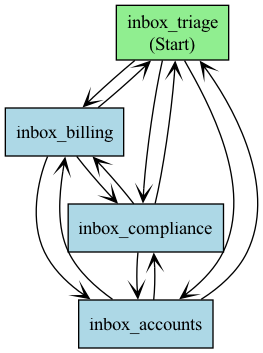

In [67]:
# 📐 Visualize the DropGo Handoff workflow
from agent_framework import WorkflowViz
from IPython.display import display, Image

viz_handoff = WorkflowViz(inbox_handoff_workflow)
print("DropGo Handoff — 4 agents with cross-department escalation")
png_handoff = viz_handoff.export(format="png", filename="images/handoff_DropGo")
display(Image(filename=png_handoff))